- Time Domain
  - Template of SCG
  - Analytic Signal and Hilbert Transform
  - Peak Detection
    - Peak of Peak Algorithm
  - Envelope Extraction
    - Envelope from Peaks
    - Average Envelope
    - Envelope and Phase Extraction using Hilbert Transform
  - Singular Spectrum Transform (SST)
  - Time Domain Feature
    - Petrosian Fractal Dimension (PFD)
    - Skewness and Kurtosis
- Frequency Domain
  - Fast Fourier Transform (FFT)
  - Frequency Domain Feature
    - Power Spectral Density (PSD)
    - Skewness and Kurtosis
- Time-Frequency Domain
  - Short Time Fourier Transform (STFT)
  - Wavelet Analysis
    - Mexican Hat Wavelet
    - Morlet Wavelet
    - Continuous Wavelet Transform (CWT)
    - Inverse CWT
  - Polynomial Chirplet Transform (PCT)
    - Chirplet Transform
    - Polynomial Chirplet Transform
  - Wigner Ville Distribution (WVD)
  - SynchroSqueezing Transform (SST)

In [158]:
from warnings import warn
import warnings
warnings.filterwarnings('ignore')
import scipy.ndimage
import scipy.signal
import math
import random
import numpy as np
import scipy
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pywt

class NeuroKitWarning(RuntimeWarning):
    """Category for runtime warnings that occur within the NeuroKit library.
    """

def listify(**kwargs):
    """Transforms arguments into lists of the same length.

    Examples
    --------
    >>> import neurokit2 as nk
    >>>
    >>> nk.listify(a=3, b=[3, 5], c=[3]) #doctest: +ELLIPSIS
    {'a': [3, 3], 'b': [3, 5], 'c': [3, 3]}

    """
    args = kwargs
    maxi = 1

    # Find max length
    for key, value in args.items():
        if isinstance(value, str) is False:
            try:
                if len(value) > maxi:
                    maxi = len(value)
            except TypeError:
                pass

    # Transform to lists
    for key, value in args.items():
        if isinstance(value, list):
            args[key] = _multiply_list(value, maxi)
        else:
            args[key] = _multiply_list([value], maxi)

    return args


def _multiply_list(lst, length):
    q, r = divmod(length, len(lst))
    return q * lst + lst[:r]

def signal_distort(
    signal,
    sampling_rate=100,
    noise_type = ["basic"],
    noise_shape="laplace",
    noise_amplitude=0,
    noise_frequency=[5,10,100],
    powerline_amplitude=0,
    powerline_frequency=50,
    signal_sd=None,
    artifacts_amplitude=0,
    artifacts_frequency=0,
    artifacts_number=5,
    artifacts_shape="laplace",
    n_echo=3, 
    attenuation_factor=[0.1, 0.05, 0.02],
    delay_factor=[5] * 3,
    random_state=None,
    silent=False,
    
):
    """Signal distortion.

    Add noise of a given frequency, amplitude and shape to a signal.

    Parameters
    ----------
    signal : Union[list, np.array, pd.Series]
        The signal (i.e., a time series) in the form of a vector of values.
    sampling_rate : int
        The sampling frequency of the signal (in Hz, i.e., samples/second).
    noise_shape : str
        The shape of the noise. Can be one of 'laplace' (default) or
        'gaussian'.
    noise_amplitude : float
        The amplitude of the noise (the scale of the random function, relative
        to the standard deviation of the signal).
    noise_frequency : float
        The frequency of the noise (in Hz, i.e., samples/second).
    powerline_amplitude : float
        The amplitude of the powerline noise (relative to the standard
        deviation of the signal).
    powerline_frequency : float
        The frequency of the powerline noise (in Hz, i.e., samples/second).
    artifacts_amplitude : float
        The amplitude of the artifacts (relative to the standard deviation of
        the signal).
    artifacts_frequency : int
        The frequency of the artifacts (in Hz, i.e., samples/second).
    artifacts_number : int
        The number of artifact bursts. The bursts have a random duration
        between 1 and 10% of the signal duration.
    linear_drift : bool
        Whether or not to add linear drift to the signal.
    random_state : int
        Seed for the random number generator. Keep it fixed for reproducible
        results.
    silent : bool
        Whether or not to display warning messages.

    Returns
    -------
    array
        Vector containing the distorted signal.

    """
    # Seed the random generator for reproducible results.
    np.random.seed(random_state)

    # Make sure that noise_amplitude is a list.
    if isinstance(noise_amplitude, (int, float)):
        noise_amplitude = [noise_amplitude]

    signal_sd = np.std(signal, ddof=1)
    if signal_sd == 0:
        signal_sd = None

    noise = 0

    # Basic noise.
    if "basic" in noise_type:
        if min(noise_amplitude) > 0:
            noise += _signal_distort_noise_multifrequency(
                signal,
                signal_sd=signal_sd,
                sampling_rate=sampling_rate,
                noise_amplitude=noise_amplitude,
                noise_frequency=noise_frequency,
                noise_shape=noise_shape,
                silent=silent,
            )
            
    if "resonance" in noise_type:
        noise += add_echo_noise(
            signal, 
            n_echo=n_echo,
            attenuation_factor=attenuation_factor,
            delay_factor=delay_factor
        )
        

    # Powerline noise.
    if "powerline" in noise_type: 
        if powerline_amplitude > 0:
            noise += _signal_distort_powerline(
                signal,
                signal_sd=signal_sd,
                sampling_rate=sampling_rate,
                powerline_frequency=powerline_frequency,
                powerline_amplitude=powerline_amplitude,
                silent=silent,
            )
    
    # Artifacts.
    if "artifacts" in noise_type:
        if artifacts_amplitude > 0:
            noise += _signal_distort_artifacts(
                signal,
                signal_sd=signal_sd,
                sampling_rate=sampling_rate,
                artifacts_frequency=artifacts_frequency,
                artifacts_amplitude=artifacts_amplitude,
                artifacts_number=artifacts_number,
                silent=silent,
            )
    
    if "linear_drift" in noise_type:
        noise += _signal_linear_drift(signal)
    
    distorted = signal + noise

    return distorted

def add_echo_noise(
    signal, n_echo=3, attenuation_factor=[0.1, 0.05, 0.02], delay_factor=[5] * 3
):
    """
    Add echo noise to a signal.

    Parameters:
    signal : array-like
        The input signal to which echo noise will be added.
    n_echo : int, optional
        The number of echo repetitions to add.
    attenuation_factor : list or numpy.ndarray, optional
        A list of attenuation factors for each echo.
    delay_factor : list or numpy.ndarray, optional
        A list of delay factors (in samples) for each echo.
    show : bool, optional
        Whether to display a plot of the noisy signal.

    Returns:
    noisy_signal : array-like
        An array containing the values of the signal with added echo noise.
    """
    # Check the types and lengths of attenuation and delay factors
    if not isinstance(attenuation_factor, (list, np.ndarray)):
        raise ValueError("The type of attenuation_factor must be a list or numpy.ndarray")
    if not isinstance(delay_factor, (list, np.ndarray)):
        raise ValueError("The type of delay_factor must be a list or numpy.ndarray")
    if len(attenuation_factor) != n_echo or len(delay_factor) != n_echo:
        raise ValueError("The lengths of attenuation_factor and delay_factor should be equal to n_echo")

    # Create a copy of the original signal
    original_signal = signal.copy()
    echos = np.zeros(shape=original_signal.shape)
    # Iterate over each echo and apply attenuation and delay
    for a_factor, d_factor in zip(attenuation_factor, delay_factor):
        # Apply attenuation to the signal
        attenuation_signal = original_signal * a_factor

        # Shift the attenuated signal to create the echo effect
        attenuation_signal[d_factor:] = attenuation_signal[:-d_factor]
        attenuation_signal[:d_factor] = 0

        # Add the attenuated and delayed signal to the original signal
        echos += attenuation_signal

    # Combine the original signal with all the echoes to create the noisy signal
#     noisy_signal = echos + signal

    return echos

def _signal_linear_drift(signal):

    n_samples = len(signal)
    linear_drift = np.arange(n_samples) * (1 / n_samples)

    return linear_drift


def _signal_distort_artifacts(
    signal,
    signal_sd=None,
    sampling_rate=100,
    artifacts_frequency=0,
    artifacts_amplitude=0.1,
    artifacts_number=5,
    artifacts_shape="laplace",
    silent=False,
):

    # Generate artifact burst with random onset and random duration.
    artifacts = _signal_distort_noise(
        len(signal),
        sampling_rate=sampling_rate,
        noise_frequency=artifacts_frequency,
        noise_amplitude=artifacts_amplitude,
        noise_shape=artifacts_shape,
        silent=silent,
    )
    if artifacts.sum() == 0:
        return artifacts

    min_duration = int(np.rint(len(artifacts) * 0.001))
    max_duration = int(np.rint(len(artifacts) * 0.01))
    artifact_durations = np.random.randint(min_duration, max_duration, artifacts_number)

    artifact_onsets = np.random.randint(0, len(artifacts) - max_duration, artifacts_number)
    artifact_offsets = artifact_onsets + artifact_durations

    artifact_idcs = np.array([False] * len(artifacts))
    for i in range(artifacts_number):
        artifact_idcs[artifact_onsets[i] : artifact_offsets[i]] = True

    artifacts[~artifact_idcs] = 0

    # Scale amplitude by the signal's standard deviation.
    if signal_sd is not None:
        artifacts_amplitude *= signal_sd
    artifacts *= artifacts_amplitude

    return artifacts


def _signal_distort_powerline(
    signal, signal_sd=None, sampling_rate=100, powerline_frequency=[5,10,100], powerline_amplitude=0, silent=False
):

    duration = len(signal) / sampling_rate
    powerline_noise = signal_simulate(
        duration=duration, sampling_rate=sampling_rate, frequency=powerline_frequency, amplitude=1, silent=silent
    )

    if signal_sd is not None:
        powerline_amplitude *= signal_sd
    powerline_noise *= powerline_amplitude

    return powerline_noise


def _signal_distort_noise_multifrequency(
    signal,
    signal_sd=None,
    sampling_rate=100,
    noise_amplitude=0.1,
    noise_frequency=100,
    noise_shape="laplace",
    silent=False,
):
    base_noise = np.zeros(len(signal))
    params = listify(noise_amplitude=noise_amplitude, noise_frequency=noise_frequency, noise_shape=noise_shape)

    for i in range(len(params["noise_amplitude"])):

        freq = params["noise_frequency"][i]
        amp = params["noise_amplitude"][i]
        shape = params["noise_shape"][i]

        if signal_sd is not None:
            amp *= signal_sd

        # Make some noise!
        _base_noise = _signal_distort_noise(
            len(signal),
            sampling_rate=sampling_rate,
            noise_frequency=freq,
            noise_amplitude=amp,
            noise_shape=shape,
            silent=silent,
        )
        base_noise += _base_noise

    return base_noise


def _signal_distort_noise(
    n_samples, sampling_rate=1000, noise_frequency=100, noise_amplitude=0.1, noise_shape="laplace", silent=False
):

    _noise = np.zeros(n_samples)
    # Apply a very conservative Nyquist criterion in order to ensure
    # sufficiently sampled signals.
    nyquist = sampling_rate * 0.1
    if noise_frequency > nyquist:
        if not silent:
            warn(
                f"Skipping requested noise frequency "
                f" of {noise_frequency} Hz since it cannot be resolved at "
                f" the sampling rate of {sampling_rate} Hz. Please increase "
                f" sampling rate to {noise_frequency * 10} Hz or choose "
                f" frequencies smaller than or equal to {nyquist} Hz.",
                category=NeuroKitWarning
            )
        return _noise
    # Also make sure that at least one period of the frequency can be
    # captured over the duration of the signal.
    duration = n_samples / sampling_rate
    if (1 / noise_frequency) > duration:
        if not silent:
            warn(
                f"Skipping requested noise frequency "
                f" of {noise_frequency} Hz since its period of {1 / noise_frequency} "
                f" seconds exceeds the signal duration of {duration} seconds. "
                f" Please choose noise frequencies larger than "
                f" {1 / duration} Hz or increase the duration of the "
                f" signal above {1 / noise_frequency} seconds.",
                category=NeuroKitWarning
            )
        return _noise

    noise_duration = int(duration * noise_frequency)

    if noise_shape in ["normal", "gaussian"]:
        _noise = np.random.normal(0, noise_amplitude, noise_duration)
    elif noise_shape == "laplace":
        _noise = np.random.laplace(0, noise_amplitude, noise_duration)
    else:
        raise ValueError("NeuroKit error: signal_distort(): 'noise_shape' should be one of 'gaussian' or 'laplace'.")

    if len(_noise) != n_samples:
        _noise = signal_resample(_noise, desired_length=n_samples)
    return _noise




def signal_resample(
    signal, desired_length=None, sampling_rate=None, desired_sampling_rate=None
):
    """Resample a continuous signal to a different length or sampling rate.

    Up- or down-sample a signal. The user can specify either a desired length for the vector, or input
    the original sampling rate and the desired sampling rate.
    See https://github.com/neuropsychology/NeuroKit/scripts/resampling.ipynb for a comparison of the methods.

    Parameters
    ----------
    signal :  Union[list, np.array, pd.Series]
        The signal (i.e., a time series) in the form of a vector of values.
    desired_length : int
        The desired length of the signal.
    sampling_rate : int
        The original sampling frequency (in Hz, i.e., samples/second).
    desired_sampling_rate : int
        The desired (output) sampling frequency (in Hz, i.e., samples/second).
    method : str
        Can be 'interpolation' (see `scipy.ndimage.zoom()`), 'numpy' for numpy's interpolation
        (see `numpy.interp()`),'pandas' for Pandas' time series resampling, 'poly' (see `scipy.signal.resample_poly()`)
        or 'FFT' (see `scipy.signal.resample()`) for the Fourier method. FFT is the most accurate
        (if the signal is periodic), but becomes exponentially slower as the signal length increases.
        In contrast, 'interpolation' is the fastest, followed by 'numpy', 'poly' and 'pandas'.

    Returns
    -------
    array
        Vector containing resampled signal values.

    See Also
    --------
    scipy.signal.resample_poly, scipy.signal.resample, scipy.ndimage.zoom

    """
    if desired_length is None:
        desired_length = int(np.round(len(signal) * desired_sampling_rate / sampling_rate))

    # Sanity checks
    if len(signal) == desired_length:
        return signal

    # Resample
    resampled = scipy.ndimage.zoom(signal, desired_length / len(signal))
    
    return resampled




def scg_simulate(
    duration=10, 
    length=None, 
    sampling_rate=100, 
    heart_rate=70, 
    heart_rate_std=1, 
    respiratory_rate=15, 
    systolic=120, 
    diastolic=80, 
    pulse_type="db", 
    noise_type = ["basic"],
    noise_shape="laplace",
    noise_amplitude=0.1,
    noise_frequency=[5,10,100],
    signal_sd = None,
    powerline_amplitude=0,
    powerline_frequency=50,
    artifacts_amplitude=0.1,
    artifacts_frequency=100,
    artifacts_number=5,
    artifacts_shape="laplace",
    n_echo=3, 
    attenuation_factor=[0.1, 0.05, 0.02],
    delay_factor=[5] * 3,
    random_state=None,
    silent=False,
):
    """Simulate an scg/EKG signal.

    Generate an artificial (synthetic) scg signal of a given duration and sampling rate using either
    the scgSYN dynamical model (McSharry et al., 2003) or a simpler model based on Daubechies wavelets
    to roughly approximate cardiac cycles.

    Parameters
    ----------
    duration : int
        Desired recording length in seconds.
    sampling_rate : int
        The desired sampling rate (in Hz, i.e., samples/second).
    length : int
        The desired length of the signal (in samples).
    noise : float
        Noise level (amplitude of the laplace noise).
    heart_rate : int
        Desired simulated heart rate (in beats per minute). The default is 70. Note that for the
        scgSYN method, random fluctuations are to be expected to mimick a real heart rate. These
        fluctuations can cause some slight discrepancies between the requested heart rate and the
        empirical heart rate, especially for shorter signals.
    heart_rate_std : int
        Desired heart rate standard deviation (beats per minute).
    method : str
        The model used to generate the signal. Can be 'simple' for a simulation based on Daubechies
        wavelets that roughly approximates a single cardiac cycle. If 'scgsyn' (default), will use an
        advanced model desbribed `McSharry et al. (2003) <https://physionet.org/content/scgsyn/>`_.
    random_state : int
        Seed for the random number generator.

    Returns
    -------
    array
        Vector containing the scg signal.

    See Also
    --------
    rsp_simulate, eda_simulate, ppg_simulate, emg_simulate


    References
    -----------
    - McSharry, P. E., Clifford, G. D., Tarassenko, L., & Smith, L. A. (2003). A dynamical model for
    generating synthetic electrocardiogram signals. IEEE transactions on biomedical engineering, 50(3), 289-294.
    - https://github.com/diarmaidocualain/scg_simulation

    """
    # Seed the random generator for reproducible results
    np.random.seed(random_state)

    # Generate number of samples automatically if length is unspecified
    if length is None:
        length = duration * sampling_rate
    if duration is None:
        duration = length / sampling_rate

    # Run appropriate method

    scg = _scg_simulate_wavelet(
        duration=duration, length=length, sampling_rate=sampling_rate, heart_rate=heart_rate, respiratory_rate=respiratory_rate,  systolic=systolic, diastolic=diastolic, pulse_type=pulse_type
    )

    # Add random noise
    if noise_amplitude > 0:
        scg = signal_distort(
            signal=scg,
            sampling_rate=sampling_rate,
            noise_type = noise_type,
            noise_shape=noise_shape,
            noise_amplitude=noise_amplitude,
            noise_frequency=noise_frequency,
            powerline_amplitude=powerline_amplitude,
            powerline_frequency=powerline_frequency,
            signal_sd=signal_sd,
            artifacts_amplitude=artifacts_amplitude,
            artifacts_frequency=artifacts_frequency,
            artifacts_number=artifacts_number,
            artifacts_shape=artifacts_shape,
            n_echo=n_echo, 
            attenuation_factor=attenuation_factor,
            delay_factor=delay_factor,
            random_state=random_state,
            silent=silent
        )

    # Reset random seed (so it doesn't affect global)
    np.random.seed(None)
    return scg


# =============================================================================
# Daubechies
# =============================================================================
def _scg_simulate_wavelet(duration=10, 
                          length=None, 
                          sampling_rate=100, 
                          heart_rate=70, 
                          respiratory_rate=15, 
                          systolic=120, 
                          diastolic=80, 
                          pulse_type="db"):
    """Generate an artificial (synthetic) scg signal of a given duration and sampling rate.

    It uses a 'Daubechies' wavelet that roughly approximates a single cardiac cycle.
    This function is based on `this script <https://github.com/diarmaidocualain/scg_simulation>`_.

    """
    # The "Daubechies" wavelet is a rough approximation to a real, single, cardiac cycle

    cardiac_length = int(100*sampling_rate/heart_rate) #sampling_rate #
    # ind = random.randint(17, 34)
    
    
    if pulse_type=="db":
        ind = random.randint(17, 34) 
        cardiac_s = scipy.signal.daub(ind)
        cardiac_d = scipy.signal.daub(ind)*0.3*diastolic/80 # change height to 0.3
        cardiac_s = scipy.signal.resample(cardiac_s, 100)
        cardiac_d = scipy.signal.resample(cardiac_d, 100)
        
    elif pulse_type=="mor":
        ind = random.randint(5, 55)
        cardiac_s = scipy.signal.morlet(40,ind/10).real
        cardiac_d = scipy.signal.morlet(40,ind/10).real*0.3*diastolic/80 # change height to 0.3
        cardiac_s = np.concatenate((cardiac_s,np.zeros(60)))
        cardiac_d = np.concatenate((cardiac_d,np.zeros(60)))

    elif pulse_type=="ricker":
        ind = random.randint(10, 30)
        cardiac_s = scipy.signal.ricker(40,i/10)
        cardiac_d = scipy.signal.ricker(40,i/10)*0.3*diastolic/80
        cardiac_s = np.concatenate((cardiac_s,np.zeros(60)))
        cardiac_d = np.concatenate((cardiac_d,np.zeros(60)))
        
    elif pulse_type=="sym":
        index = np.array([3, 5, 7, 9, 11, 12, 13, 14, 15, 16, 17, 19])
        ind = np.random.choice(index)
        wavelet = pywt.Wavelet(f"sym{ind}")
        phi, psi, x = wavelet.wavefun(level=1)
        psi = np.concatenate((psi,np.zeros(100-len(psi))))
        cardiac_s = psi
        cardiac_d = psi*0.3*diastolic/80
    
    else:
        raise Exception("The pulse_type contains: db, mor, ricker, sym")

    
    
    cardiac_s = cardiac_s[0:40]
    distance = 180-systolic 
    # distance = cardiac_length - len(cardiac_s) - len(cardiac_d) - systolic # here 140 = 40 (cardiac_s) + 100 (cardiac_d) as below
    zero_signal = np.zeros(distance)
    cardiac = np.concatenate([cardiac_s, zero_signal, cardiac_d])
    # cardiac = scipy.signal.resample(cardiac, 100) # fix every cardiac length to 100
    cardiac = scipy.signal.resample(cardiac, cardiac_length) # fix every cardiac length to 1000/heart_rate

    # Caculate the number of beats in capture time period
    num_heart_beats = int(duration * heart_rate / 60)

    # Concatenate together the number of heart beats needed
    scg = np.tile(cardiac, num_heart_beats)

    # Change amplitude
    # scg = scg * 10
    # scg = scg * 10

    # Resample
    scg = signal_resample(
        scg, sampling_rate=int(len(scg) / 10), desired_length=length, desired_sampling_rate=sampling_rate
    )

    # max_peak = max(scg)
    # peak_threshold = max_peak/s_d + 0.1
    # peaks, _ = scipy.signal.find_peaks(scg, height=peak_threshold)
    
    ### add rr
    num_points = duration * sampling_rate
    x_space = np.linspace(0,1,num_points)
    seg_fre = respiratory_rate / (60/duration)
    seg_amp = max(scg) * 0.00001
    rr_component = seg_amp * np.sin(2 * np.pi * seg_fre * x_space)
    
    scg *= (rr_component + 2 * seg_amp)
    
    return scg




def scg(num_rows=1,
        duration=10, 
        sampling_rate=100,
        length=None,
        pulse_type="db",
        noise_type=["basic"],
        noise_shape="laplace",
        noise_amplitude=0.1,
        noise_frequency=[5,10,100],
        signal_sd = None,
        powerline_amplitude=0,
        powerline_frequency=50,
        artifacts_amplitude=0,
        artifacts_frequency=100,
        artifacts_number=5,
        artifacts_shape="laplace",
        n_echo=3, 
        attenuation_factor=[0.1, 0.05, 0.02],
        delay_factor=[5] * 3,
        random_state=None,
        silent=False,
        heart_rate_min=50,
        heart_rate_max=150, 
        respiratory=True,
        respiratory_rate_min=10,
        respiratory_rate_max=30,
        s_min=90,
        s_max=140,
        d_min=60,
        d_max=100,
        data_file="./data.npy"
        ):
    
    N = num_rows
    fs = sampling_rate
    duration = duration # 10 seconds
    simulated_data = []

    for ind in tqdm(range(N)):
        heart_rate = random.randint(heart_rate_min, heart_rate_max)
        respiratory_rate = random.randint(respiratory_rate_min, respiratory_rate_max)

        systolic = random.randint(s_min, s_max)
        diastolic = random.randint(d_min, d_max) #+ systolic

        print('hr:', heart_rate, 'rr:', respiratory_rate, 
              'sp:', systolic, 'dp:', diastolic)
       
        data = scg_simulate(duration=duration, 
               length=length, 
               sampling_rate=sampling_rate, 
               heart_rate=heart_rate,  
               respiratory_rate=respiratory_rate, 
               systolic=systolic, 
               diastolic=diastolic, 
               pulse_type=pulse_type, 
               noise_type = noise_type,
               noise_shape= noise_shape,
               noise_amplitude= noise_amplitude,
               noise_frequency=noise_frequency,
               signal_sd = signal_sd,
               powerline_amplitude=powerline_amplitude,
               powerline_frequency=powerline_frequency,
               artifacts_amplitude=artifacts_amplitude,
               artifacts_frequency=artifacts_frequency,
               artifacts_number=artifacts_number,
               artifacts_shape=artifacts_shape,
               n_echo=n_echo, 
               attenuation_factor=attenuation_factor,
               delay_factor=delay_factor,
               random_state=random_state,
               silent=silent)
        ## N + 6 size. 6 are [mat_int(here 0 for synthetic data), time_stamp, hr, rr, sbp, dbp]
        simulated_data.append(list(data)+[0]+[ind]+[heart_rate]+[respiratory_rate]+[systolic]+[diastolic])

    simulated_data = np.asarray(simulated_data)
    np.save(data_file,simulated_data)
    print(f'{data_file} is generated and saved!')

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 472.65it/s]

hr: 136 rr: 25 sp: 114 dp: 100
./data.npy is generated and saved!


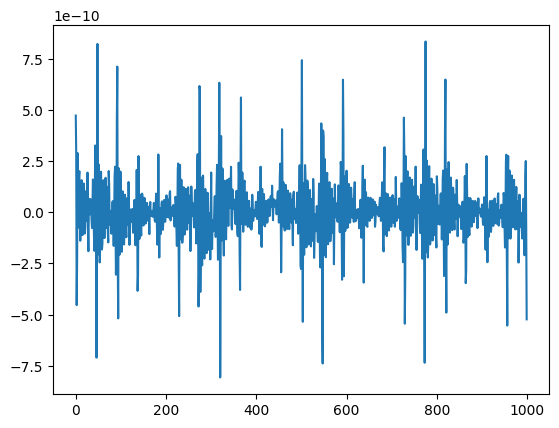

In [199]:
scg(num_rows=1,
    duration=10,
    sampling_rate=100,
    pulse_type="morlet",
    noise_type=["basic"],
    noise_amplitude=0.1,
    heart_rate_min=50,
    heart_rate_max=150, 
    respiratory=True,
    respiratory_rate_min=10,
    respiratory_rate_max=30,
    s_min=90,
    s_max=140,
    d_min=60,
    d_max=100,
    data_file="./data.npy"
    )
signal = np.load("./data.npy")
plt.plot(signal[0,:1000])
plt.show()

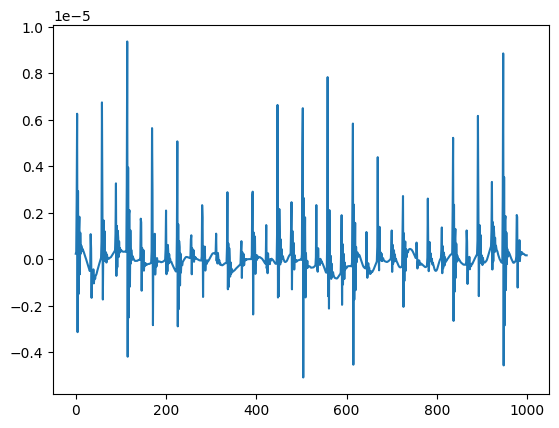

[6.45985772e-07 4.99057927e-07 4.54850097e-07 4.06185556e-07
 3.64529374e-07 3.35780843e-07 3.10499112e-07 2.74890925e-07
 2.24058648e-07 1.64698744e-07]
[1.13639131e-06 2.34360108e-07 5.92462891e-07 5.35582416e-07
 3.44550050e-07 4.45598425e-07 3.95338960e-07 3.52215441e-07
 2.93110193e-07 2.26668738e-07]


In [179]:
signal1 = signal[0,:1000]
signal2=signal1+add_echo_noise(signal1)
plt.plot(signal2)
plt.show()
print(signal1[10:20])
print(signal2[10:20])

In [ ]:
import 
if pulse_type == "db":
    ind = random.randint(1, 10)  # Daubechies 小波通常从 1 开始编号
    wavelet = pywt.Wavelet(f'db{ind}')
elif pulse_type == "sym":
    ind = random.randint(2, 10)  # Symlets 小波通常从 2 开始编号
    wavelet = pywt.Wavelet(f'sym{ind}')
elif pulse_type == "bior":
    ind = random.randint(1, 6)  # Biorthogonal 小波的编号有不同的规则，这里只是一个示例
    wavelet = pywt.Wavelet(f'bior{ind}.{ind}')
elif pulse_type == "coif":
    ind = random.randint(1, 5)  # Coiflets 小波通常从 1 开始编号
    wavelet = pywt.Wavelet(f'coif{ind}')

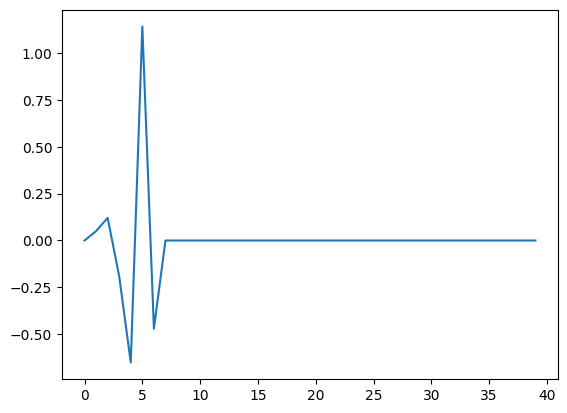

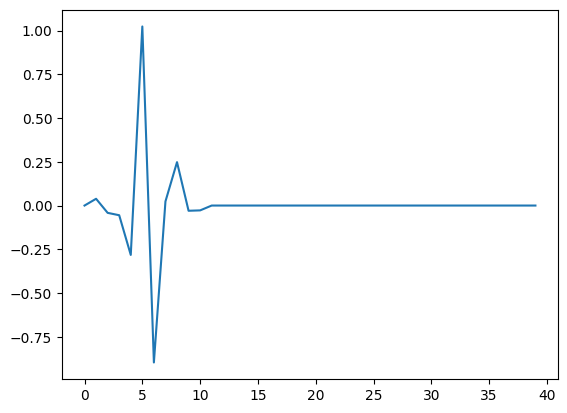

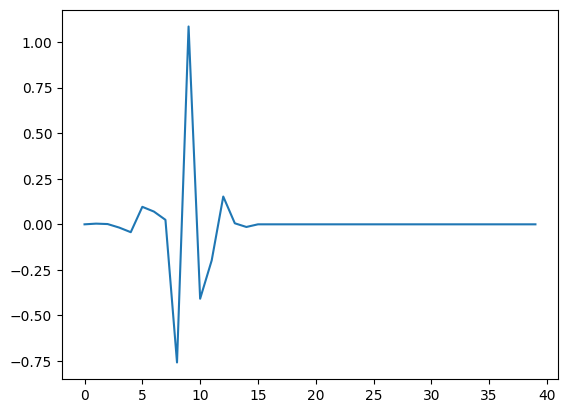

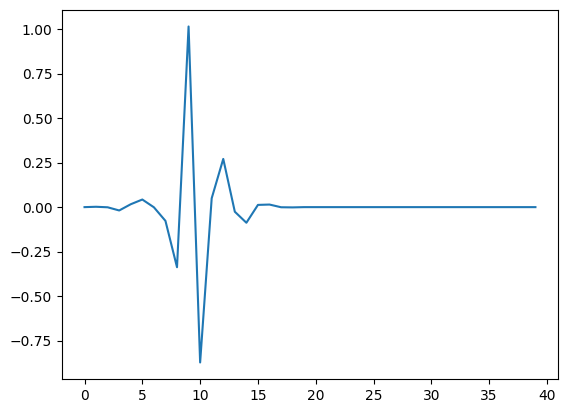

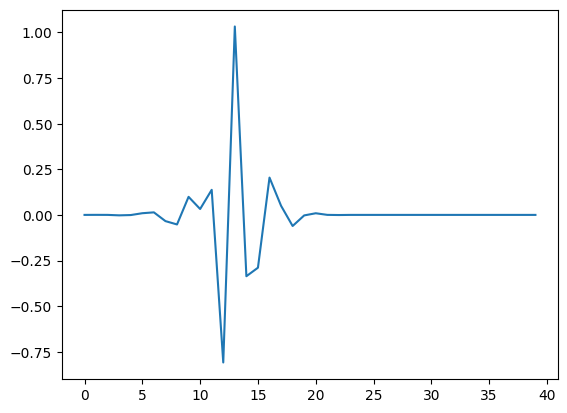

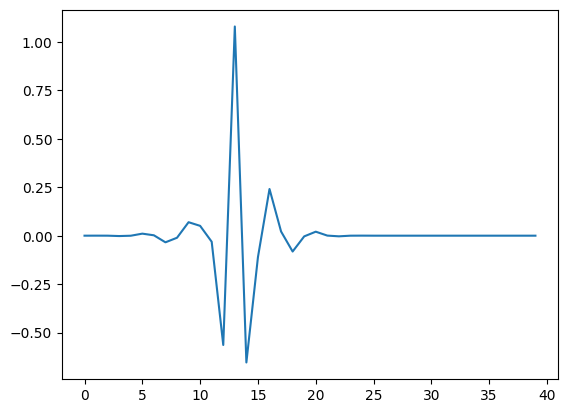

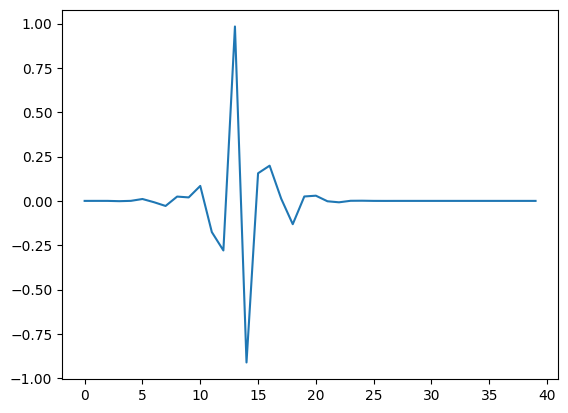

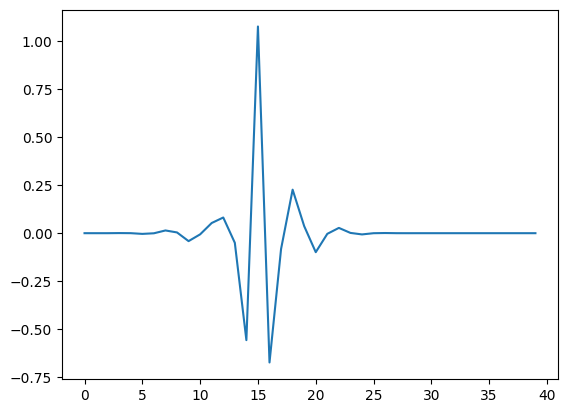

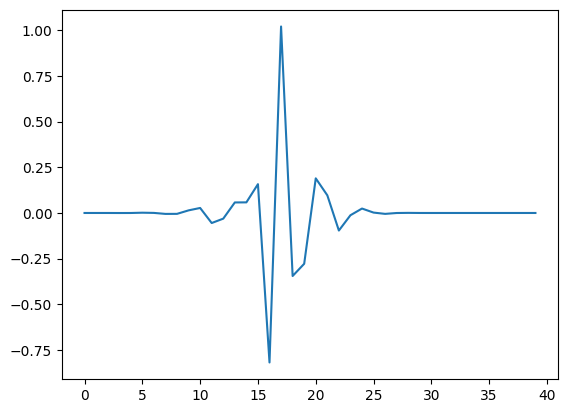

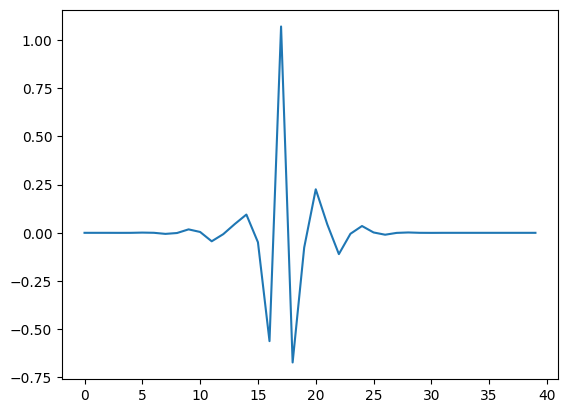

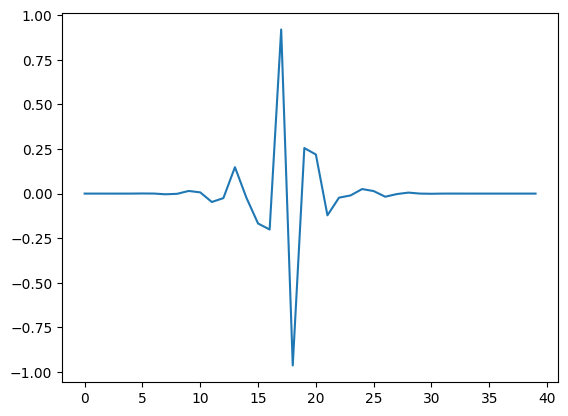

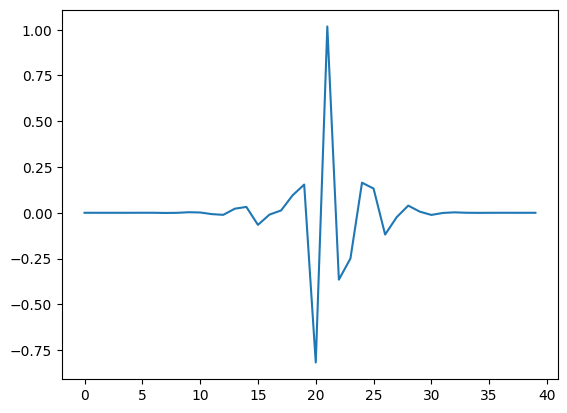

In [79]:
import scipy
import pywt
index = np.array([3, 5, 7, 9, 11, 12, 13, 14, 15, 16, 17, 19])
for i in range(len(index)):
#     print(i)
    wavelet = pywt.Wavelet(f"sym{index[i]}")
    phi, psi, x = wavelet.wavefun(level=1)
#     print(psi.shape)
    psi = np.concatenate((psi,np.zeros(100-len(psi))))
#     psi = scipy.signal.resample(psi, 100)
    psi=psi[:40]
    plt.plot(psi)
    plt.show()
    

# Time Domain

## Template of SCG
It is a simple method to get the template of the synthesized scg signal, using cluster and average. The algorithm is as follows:
1. Use the middle of peaks to segment the signal.
2. Add a new segment to the existing clusters, whose middle has the least RMSE distance with the signal. If there is no existing cluster, use the new segment as the middle of a new cluster. If the least RMSE distance is greater than a threshold, create a new cluster too.
3. Continue the former step until all the segments belong to a cluster.
4. Use the average of the cluster which has the most segments as the template.

Note: It is only suitable for the synthesized scg signal and is a simplified version.

Help on function get_template in module dsp:

get_template(signal, threshold=5e-06)
    Description:
        use cluster method to get the template
    Args:
        signal: the periodic signal
    Returns:
        The template of the periodic signal



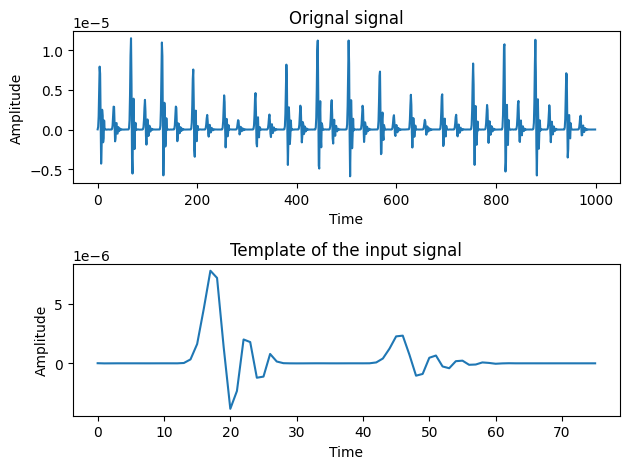

In [51]:
import numpy as np
from matplotlib import pyplot as plt
from dsp import get_template, scg

help(get_template)

signal = scg()
template = get_template(signal)

fig, axis = plt.subplots(2,1)
axis[0].set_title("Orignal signal")
axis[0].set_xlabel("Time")
axis[0].set_ylabel("Amplitude")
axis[0].plot(signal)

axis[1].set_title("Template of the input signal")
axis[1].set_xlabel("Time")
axis[1].set_ylabel("Amplitude")
axis[1].plot(template)

plt.tight_layout()
plt.show()

## Analytic Signal and Hilbert Transform

Fourier Transform of a real-valued signal is complex-symmetric whose negative frequencies are redundant with respect to the positive frequencies. To remove the redundancy, the analytic signal is invented. It is complex-valued but its spectrum will be one-sided (only positive frequencies) that preserved the spectral content of the original real-valued signal. Using an analytic signal instead of the original real-valued signal, is useful in many signal processing applications. For example, in spectral analysis, use of analytic signal in-lieu of the original real-valued signal mitigates estimation biases and eliminates cross-term artifacts due to negative and positive frequency components.

In the frequency domain, the analytic signal has only the postive part of the original signal and the magnitude is two times of the orignal postive spectrum. In the time domain, the real part of the analytic signal is the same as the original signal, but it has a imaginary part.
$$
z(t) = z_{r}(t) + z_{i}(t) = x(t) + z_{i}(t)
$$
where $z(t)$ denotes the time domain analytic singal, and $x(t)$ denotes the original signal. The subscripts $i$ and $r$ mean the imaginary and real.

So what's the imaginary part? Hilbert Transformation can be used to find the imaginary part of the orignal real-valude signal.
$$
z(t) = z_{r}(t) + z_{i}(t) = x(t) + jHT\{x(t)\}
$$
$$
HT\{x(t)\} = x(t) * \frac{1}{\pi t} \longleftrightarrow F(f)[-jsgn(f)] = \begin{cases}-jF(f) & f > 0 \\ jF(f) & f< 0 \end{cases}
$$
where $j$ is an imaginary unit, $HT\{\}$ denotes hilbert transform, $F()$ denotes the spectrum of the original signal, * denotes the convolution, $\longleftrightarrow$ denotes the mutual conversion of signals between the time domain and the frequency domain, $sgn()$ denotes the sign function, which returns -1 for negative numbers, 0 for zero, and 1 for positive numbers.

We can take the hilbert transformation as a filter whose impulse response is $\frac{1}{\pi t}$. And the HT\{x(t)\} has some properties.
1. HT\{HT\{x(t)\}\} = -x(t)
2. HT\{x(t)\} has the opposite parity of x(t)
3. HT\{x(t)\} and x(t) are orthogonal

Help on function analytic_signal in module dsp:

analytic_signal(x)
    Description:
        Get the analytic version of the input signal
    Args:
        x: input signal which is a real-valued signal
    Returns:
        The analytic version of the input signal which is a complex-valued signal

Help on function hilbert_transform in module dsp:

hilbert_transform(x)
    Description:
        Get the hilbert transformation of the input signal
    Args:
        x: a real-valued singal
    Returns:
        Return the result of hilbert transformation which is the imaginary part of the analytic signal. It is a
        real-valued number.



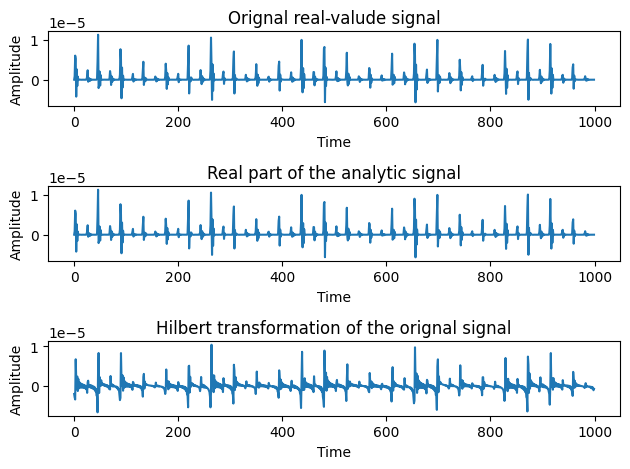

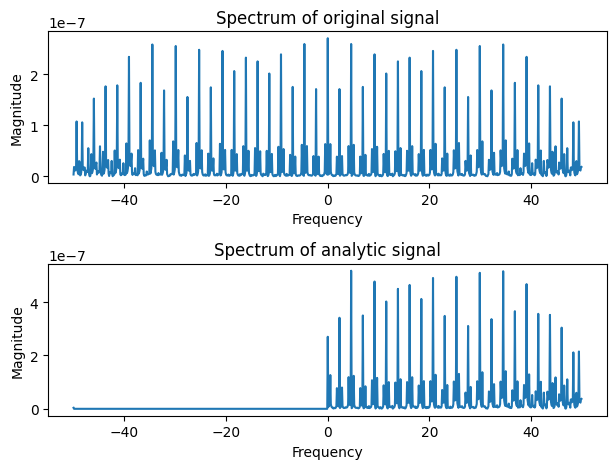

In [13]:
import numpy as np
from matplotlib import pyplot as plt
from dsp import analytic_signal, hilbert_transform, my_fft, scg

help(analytic_signal)
help(hilbert_transform)

signal = scg()
z = analytic_signal(signal)

fig, axis = plt.subplots(3,1)
axis[0].set_title("Orignal real-valude signal")
axis[0].set_xlabel("Time")
axis[0].set_ylabel("Amplitude")
axis[0].plot(signal)

axis[1].set_title("Real part of the analytic signal")
axis[1].set_xlabel("Time")
axis[1].set_ylabel("Amplitude")
axis[1].plot(z.real)

axis[2].set_title("Hilbert transformation of the orignal signal")
axis[2].set_xlabel("Time")
axis[2].set_ylabel("Amplitude")
axis[2].plot(hilbert_transform(signal))
plt.tight_layout()
plt.show()

freq_original, mag_original = my_fft(signal, 100)
freq_analytic, mag_analytic = my_fft(z, 100)

fig, axis = plt.subplots(2,1)
axis[0].set_title("Spectrum of original signal")
axis[0].plot(freq_original, np.abs(mag_original))
axis[0].set_xlabel("Frequency")
axis[0].set_ylabel("Magnitude")

axis[1].set_title("Spectrum of analytic signal")
axis[1].plot(freq_analytic, np.abs(mag_analytic))
axis[1].set_xlabel("Frequency")
axis[1].set_ylabel("Magnitude")

plt.tight_layout()
plt.show()

## Peak Detection

### Peak of Peak Algorithm
The algorithm first use scipy.signal.find_peaks to detect all the peaks in a signal and perform linear interpolation to obtain an envelope which still preserve the shape of the original signal and the peak location. After getting the envelope, we use scipy.signal.find_peaks to detect the peaks in the envelope and filter the abnormal value to get the time of all peaks.

Usage Scenario: There are many high frequency noises and the noises don't influence the shape of the original signal.

Help on function get_peaks in module dsp:

get_peaks(signal)
    Description:
        Detect peaks in a signal and perform linear interpolation to obtain an envelope.
    
    Params:
        signal (numpy.ndarray): The input signal.
    
    Returns:
        peaks (numpy.ndarray): An array containing the indices of the detected peaks.



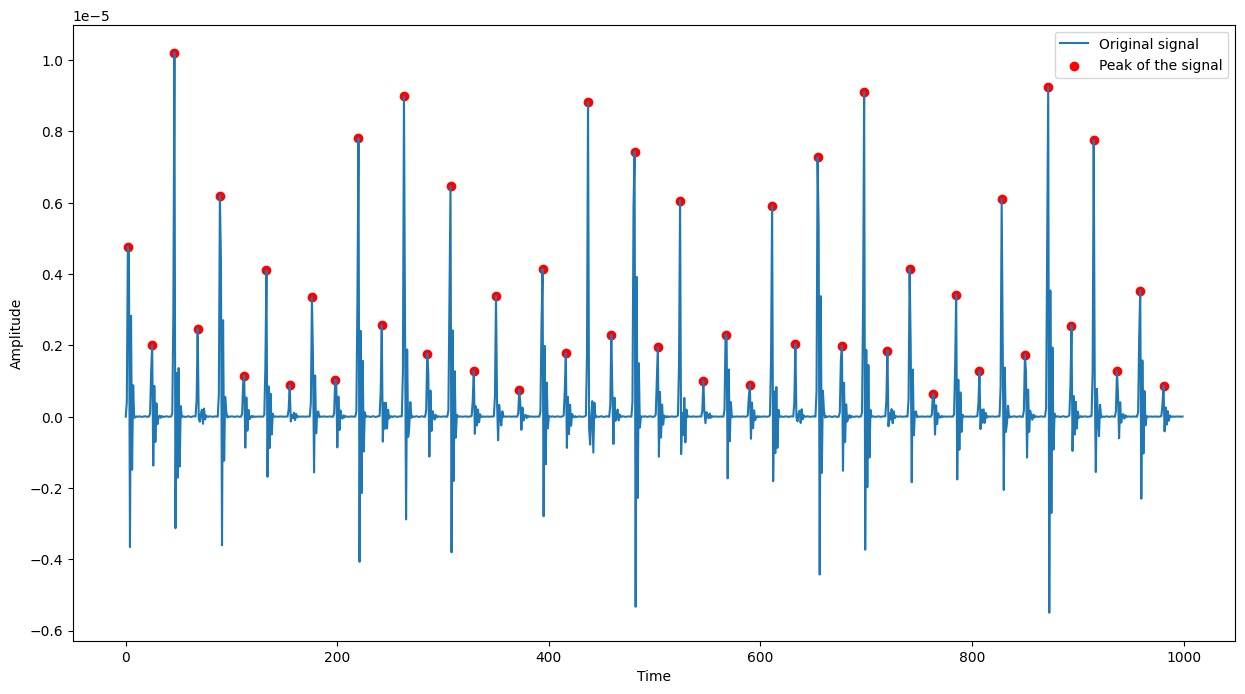

In [53]:
from dsp import get_peaks, scg
import numpy as np
import matplotlib.pyplot as plt

help(get_peaks)

signal = scg()
peaks = get_peaks(signal)
plt.figure(figsize=(15,8))
plt.plot(signal, label="Original signal")
plt.scatter(peaks,signal[peaks],c="red", label="Peak of the signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

## Envelope Extraction

### Envelope from Peaks
We can use the first step of peak of peak algorithm as a kind of envelope generation algorithm. We can perform linear interpolation of all peaks to obtain an envelope.

Usage Scenario: We only focus on locations of peaks on the envelope.

Help on function envelope_from_peaks in module dsp:

envelope_from_peaks(signal)
    Description
        Interpolation the peaks to get the envelope of the input signal. The algorithm is only suitable for the signal
        with a lot of noise
    Args:
        signal: The input signal
    Returns:
        envelope: The envelope of the input signal



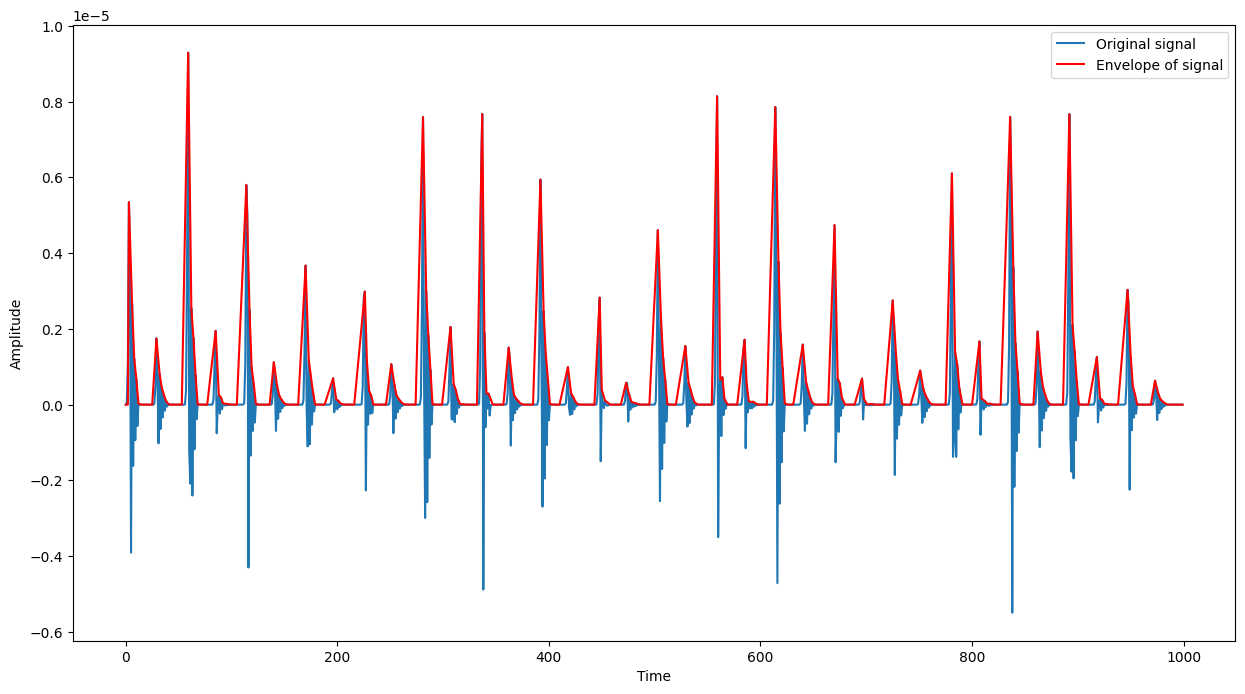

In [54]:
from dsp import envelope_from_peaks, scg
import numpy as np
import matplotlib.pyplot as plt

help(envelope_from_peaks)

signal = scg()
envelope = envelope_from_peaks(signal)
plt.figure(figsize=(15,8))
plt.plot(signal,label="Original signal")
plt.plot(envelope,c="red", label="Envelope of signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

### Average Envelope
We can also use the average window to get the envelope. The average window will calculate the average value of a region to replace the middle timestamp in the region. The longer the window, the smoother the envelope, but the more serious it will change the shape of the original signal.
$$
    envelope[i]~=~signal[i-\frac{window\_length}{2}]~+~....~+~signal[i]~+~....~+~signal[i+\frac{window\_length}{2}]
$$

Usage Scenario: It is suitable for signals with relatively stable periodicity and slow amplitude variations. This is because the moving average window can eliminate high-frequency noise while preserving the low-frequency characteristics of the signal. However, this envelope will lose the information of peaks' vertical location.

Help on function average_envelope in module dsp:

average_envelope(signal, window_length)
    Description:
        Use the average window to get the envelope
    Args:
        signal: input signal
        window_length: the length of the average window
    Returns:
        envelope: the envelope of the input signal



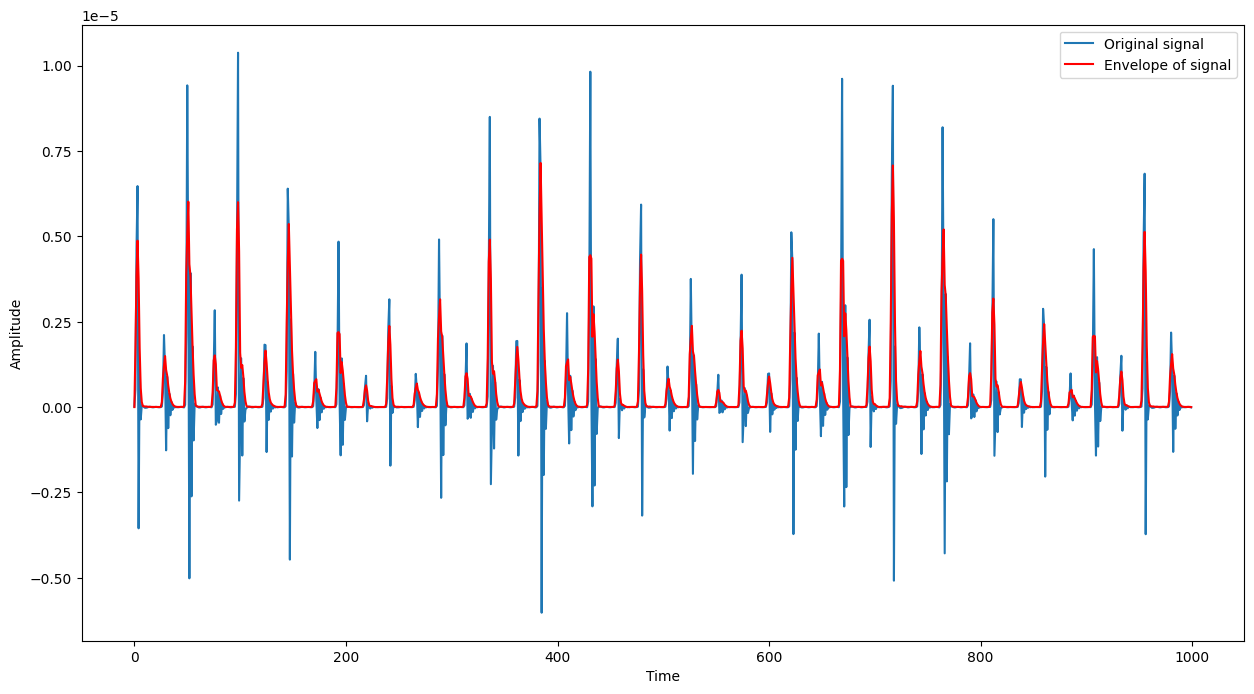

In [55]:
from dsp import average_envelope, scg
import numpy as np
import matplotlib.pyplot as plt

help(average_envelope)

signal = scg()
envelope = average_envelope(signal, 3)
plt.figure(figsize=(15,8))
plt.plot(signal,label="Original signal")
plt.plot(envelope,c="red",label="Envelope of signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

### Envelope and Phase Extraction using Hilbert Transform

If a modulated signal is expressed as $x(t) = a(t) cos[ \phi (t)]$

The instantaneous amplitude or the envelope of the signal is given by $a(t)$

The instantaneous phase is given by  $\phi(t)$

The instantaneous angular frequency is derived as $\omega(t) = \frac{d}{dt} \phi(t)$

The instantaneous temporal frequency is derived as $f(t) = \frac{1}{2 \pi} \frac{d}{dt} \phi(t)$

We note that the modulated signal is a real-valued signal. We also take note of the fact that amplitude/phase and frequency can be easily computed if the signal is expressed in complex form. So we can use Hilbert transformation to transform the real-valued signal to a complex version.

The analytic signal is
$$
z(t) = z_{r}(t) + z_{i}(t) = x(t) + jHT\{x(t)\}
$$
So
$$
a(t) = |z(t)| = \sqrt{z_r^2(t) + z_i^2(t)}
$$
$$
\phi(t) = \angle z(t) = arctan \left[ \frac{z_i(t)}{z_r(t)} \right]
$$
$$
f(t) = \frac{1}{2 \pi} \frac{d}{dt} \phi(t)
$$

where $z(t)$ denotes the analytic signal, the subscripts $i$ and $r$ mean the imaginary and real, $j$ is an imaginary unit, and $HT\{\}$ denotes hilbert transform.

Usage Scenario: It is suitable for signals with non-stationary and rapidly varying amplitudes. It is particularly effective for signals with high-frequency components, as it can accurately capture the envelope by estimating the instantaneous amplitude of the signal.

Help on function inst_amplitude in module dsp:

inst_amplitude(signal)
    Description:
        Use hilbert transformation to compute the instantaneous amplitude or the envelope of the input signal
    Args:
        signal: input signal
    Returns:
        The instantaneous amplitude or the envelope of the signal

Help on function inst_phase in module dsp:

inst_phase(signal)
    Description:
        Use hilbert transformation to compute the instantaneous phase of the input signal
    Args:
        signal: input signal
    Returns:
        instantaneous phase

Help on function inst_freq in module dsp:

inst_freq(signal, fs)
    Description:
        Use hilbert transformation to compute the instantaneous temporal frequency of the input signal
    Args:
        signal: input signal
        fs: frequency of sampling of input signal
    Returns:
        the instantaneous temporal frequency



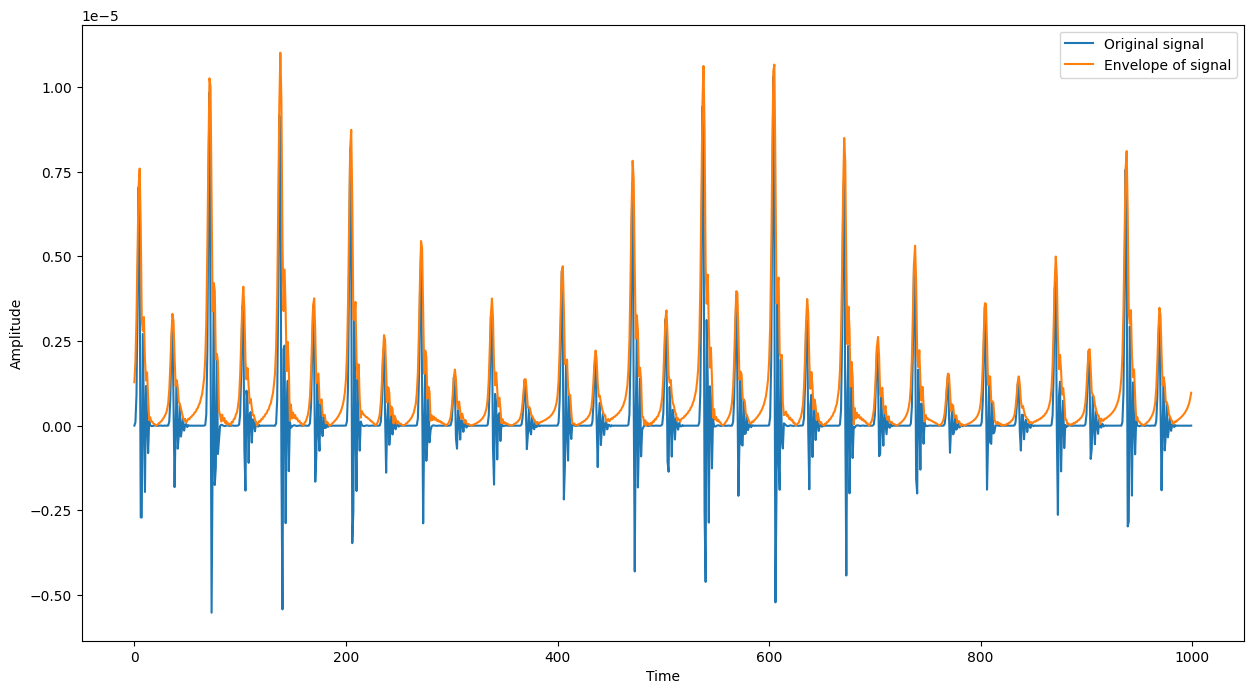

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from dsp import inst_amplitude, inst_phase, inst_freq, scg

help(inst_amplitude)
help(inst_phase)
help(inst_freq)

signal = scg()

plt.figure(figsize=(15, 8))
plt.plot(signal,label="Original signal")
plt.plot(inst_amplitude(signal),label="Envelope of signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

## Singular Spectrum Transform (SST)

SST is a signal processing technique based on singular spectrum analysis, used for extracting trends and periodic components in a signal. SST is primarily employed for decomposing signals and reconstructing their components to better understand the structure and features of the signal. This technique is usually used for the change point detection. In the example, we can find that where the signal changes a lot has a relative high score.

The main steps of SST include:

1. **Embedding**:
   Convert the original signal into matrix form. This often involves creating a Hankel matrix where rows and columns consist of subsequences of the original signal. This embedding process helps capture local structures in the signal.

2. **Singular Value Decomposition (SVD)**:
   Perform singular value decomposition on the embedded matrix, breaking it down into three matrices: U, Σ, and V^T. Here, U contains the left singular vectors, Σ contains the singular values in a diagonal matrix, and V^T contains the right singular vectors.

3. **Grouping and Reconstruction**:
   Group the singular values based on their magnitudes into several subsequences. These subsequences correspond to different frequency and trend components of the signal. By selecting relevant combinations of singular values, different components of the original signal can be reconstructed.

4. **Back-Transformation**:
   Perform the inverse transformation on the decomposed subsequences to obtain an estimate of the original signal. This step involves reversing the embedding operation on the reconstructed subsequences.

Help on function sst in module dsp:

sst(signal, win_length)
    Description:
        It is a change point detection algorithm
    Args:
        signal: the input signal
        win_length: window length of Hankel matrix
    Returns:
        score: an array measuring the degree of change



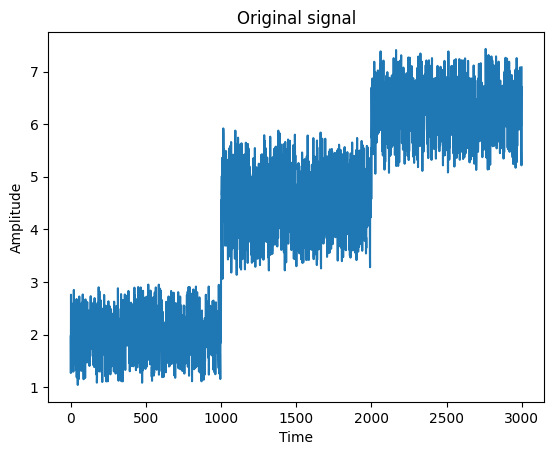

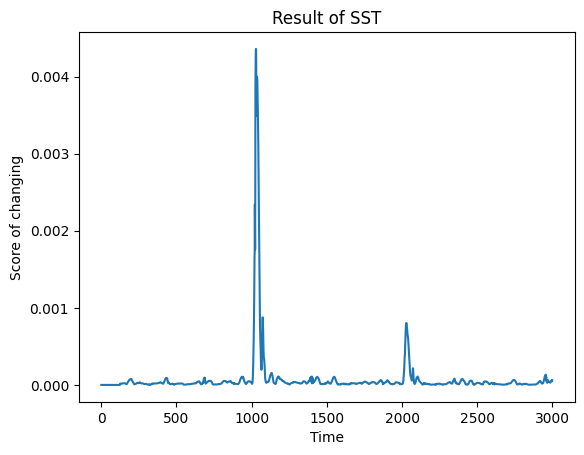

In [57]:
from dsp import sst
import numpy as np
import matplotlib.pyplot as plt

help(sst)

x0 = 1 * np.ones(1000) + np.random.rand(1000) * 1
x1 = 3 * np.ones(1000) + np.random.rand(1000) * 2
x2 = 5 * np.ones(1000) + np.random.rand(1000) * 1.5
signal = np.hstack([x0, x1, x2])
signal +=  np.random.rand(signal.size)

score = sst(signal, win_length=50)

plt.title("Original signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.plot(signal)
plt.show()

plt.title("Result of SST")
plt.plot(score)
plt.xlabel("Time")
plt.ylabel("Score of changing")
plt.show()

## Time Domain Feature

### Petrosian Fractal Dimension (PFD)

Petrosian Fractal Dimension (PFD) is a method used to measure the complexity of time-series signals, particularly applicable in biomedical signals such as electrocardiograms (ECG). It calculates the fractal dimension of a signal to describe its complexity and irregularity. A higher Petrosian Fractal Dimension value indicates a more complex signal.
$$
PFD = \frac{\log_{10}(N)}{\log_{10}(N) + \log_{10}\left(\frac{N}{N + 0.4N_{\text{zc}}}\right)}
$$
where $N$ is the length of the signal and $N_{zc}$ is the number of zero crossings in the signal derivative.

The example shows that the signal with noise is more complex than the original signal, so that the noisy signal has a bigger PFD than the orignal signal.

Help on function pfd in module dsp:

pfd(signal)
    Description:
        It calculates the fractal dimension of a signal to describe its complexity and irregularity. A higher Petrosian
        Fractal Dimension value indicates a more complex signal.
    Args:
        signal: The input signal
    Returns:
        The value of pfd



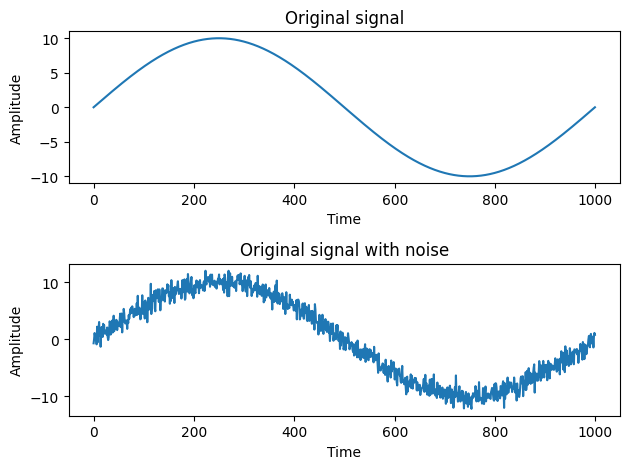

PFD of original signal:  1.0001157789650048
PFD of original signal with noise:  1.0349590443533023


In [58]:
import numpy as np
from dsp import get_template, pfd, average_envelope
import matplotlib.pyplot as plt

help(pfd)

t = np.linspace(0,1,1000)

# Generate a signal
signal1 = 10 * np.sin(2*np.pi*t)

# Add noise to the signal
signal2 = 10 * np.sin(2*np.pi*t) + np.random.randn(1000)

fig, axis = plt.subplots(2,1)
axis[0].plot(signal1)
axis[0].set_title("Original signal")
axis[0].set_xlabel("Time")
axis[0].set_ylabel("Amplitude")

axis[1].plot(signal2)
axis[1].set_title("Original signal with noise")
axis[1].set_xlabel("Time")
axis[1].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()

print("PFD of original signal: ",pfd(signal1))
print("PFD of original signal with noise: ", pfd(signal2))

### Skewness and Kurtosis
Skewness is a statistical measure that describes the degree of asymmetry of a distribution. It quantifies the extent to which a distribution deviates from symmetry around its mean.
$$
Skewness = E[(X - μ)^3] / σ^3
$$
where $E$ is the expected value operator,$X$ is the random variable, $μ$ is the mean of the distribution, $σ$ is the standard deviation of the distribution. A skewness value > 0 means there is more weight in the right tail of the distribution. A skewness value < 0 means there is more weight in the left tail of the distribution.

Kurtosis is a statistical measure that describes the "tailedness" of a distribution. It measures the thickness of the tails of a distribution relative to the rest of the data.
$$
Kurtosis = E[(X - μ)^4] / σ^4 - 3
$$
where $E$ is the expected value operator, $X$ is the random variable, $μ$ is the mean of the distribution, $σ$ is the standard deviation of the distribution. The subtraction of 3 in Fisher's definition adjusts the kurtosis so that the normal distribution has a kurtosis of zero. Positive kurtosis indicates a "leptokurtic" distribution with heavier tails and a sharper peak. Negative kurtosis indicates a "platykurtic" distribution with lighter tails and a flatter peak.

From the example below we can find that if the distribution is left-skewed, the skewness is positive and the more left-skewed, the greater is skewness is. And the skewness of right-skewed distribution is negative. And, the shaper the peak of distribution is, the greater the kurtosis is.

Note: the two statistic feature measures the distribution of an array, not the shape of the array itself.

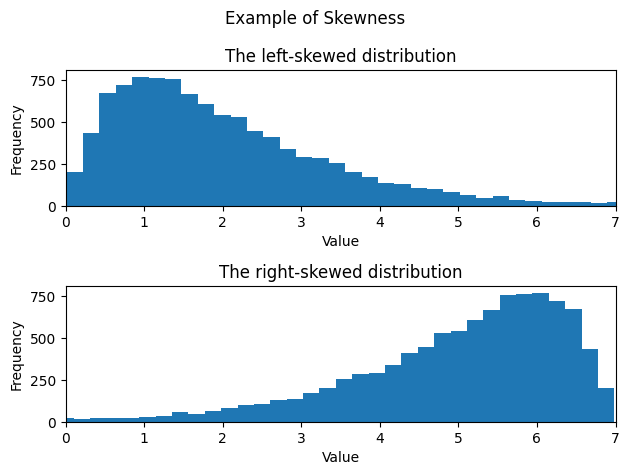

Skewness of left-skewed distribution is:  1.4511483541899584
Skewness of right-skewed distribution is:  -1.4511483541899584


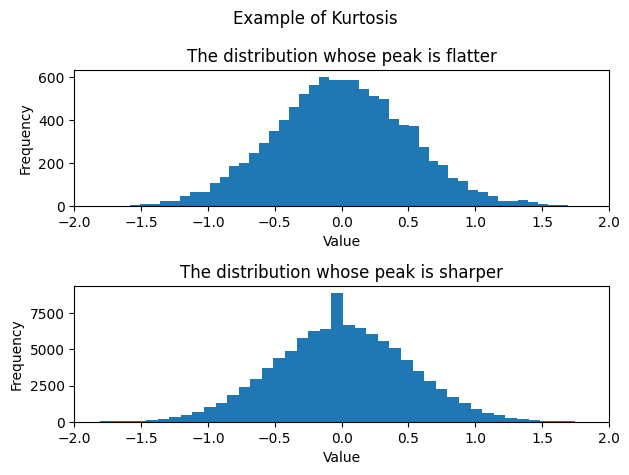

Kurtosis of distribution with flatter peak:  -0.0015705520931557082
Kurtosis of distribution with sharper peak:  0.06286752477727431


In [59]:
from scipy.stats import kurtosis, skew
import numpy as np
import matplotlib.pyplot as plt

array1 = np.random.gamma(shape=2, scale=1, size=10000)  # Generate a left-skewed distribution
array2 = 1-array1  # Generate a right-skewned distribution
array3 = np.random.normal(loc=0, scale=0.5, size=10000) # Generate a distribution whose peak is flat
array4 = np.random.normal(loc=0, scale=0.5, size=98000) # Generate a distribution whose peak is sharp
array4 = np.append(array4,np.zeros(2000))

fig, axis = plt.subplots(2,1)
fig.suptitle("Example of Skewness")
axis[0].hist(array1, bins=70)
axis[0].set_title('The left-skewed distribution')
axis[0].set_xlabel('Value')
axis[0].set_ylabel('Frequency')
axis[0].set_xlim(0,7)
axis[1].hist(7-array1, bins=70)
axis[1].set_title('The right-skewed distribution')
axis[1].set_xlabel('Value')
axis[1].set_ylabel('Frequency')
axis[1].set_xlim(0,7)
plt.tight_layout()
plt.show()

print("Skewness of left-skewed distribution is: ", skew(array1))
print("Skewness of right-skewed distribution is: ", skew(array2))


fig, axis = plt.subplots(2,1)
fig.suptitle("Example of Kurtosis")
axis[0].hist(array3, bins=50)
axis[0].set_title('The distribution whose peak is flatter')
axis[0].set_xlabel('Value')
axis[0].set_ylabel('Frequency')
axis[0].set_xlim(-2,2)
axis[1].hist(array4, bins=50)
axis[1].set_title('The distribution whose peak is sharper')
axis[1].set_xlabel('Value')
axis[1].set_ylabel('Frequency')
axis[1].set_xlim(-2,2)
plt.tight_layout()
plt.show()

print("Kurtosis of distribution with flatter peak: ", kurtosis(array3))
print("Kurtosis of distribution with sharper peak: ", kurtosis(array4))

# Frequency Domain

## Fast Fourier Transform (FFT)

FFT is a fast algorithm to calculate the DFT, whose formula is as follows:
$$
X[k] = \sum_{n=0}^{N-1}x[n]e^{-j2\pi kn/N}
$$
$$
x[n] = \frac{1}{2\pi}\sum_{k=0}^{N-1}X[k]e^{j2\pi kn/N}
$$
where $X$ denotes the result of DFT which is the spectrum, $x$ denotes the time-domain signal and $j$ is the imaginary unit. The value of spectrum indicates how much a frequency component is in the signal.

The core function to get the fft result is scipy.fft. It takes an 1d array as input and output the value of frequency component. The length of the output is the same as the length of the input signal. The value of frequency term $f=k/N$ is found at $X[k]$. At $X[N/2]$ we reach the Nyquist frequency and wrap around to the negative-frequency terms. So, for an 8-point transform, the frequencies of the result are $[0, 1, 2, 3, -4, -3, -2, -1]$. Due to scipy.fft doesn't take the sampling rate as parameter, it assume that the total lenght of the signal is 1 second and the fs is $N$.

For the convenience of illustration, we assume the input signal is real-valued. Here is an example:

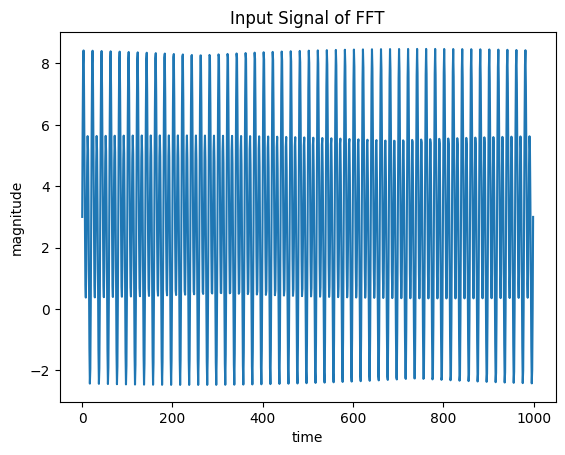

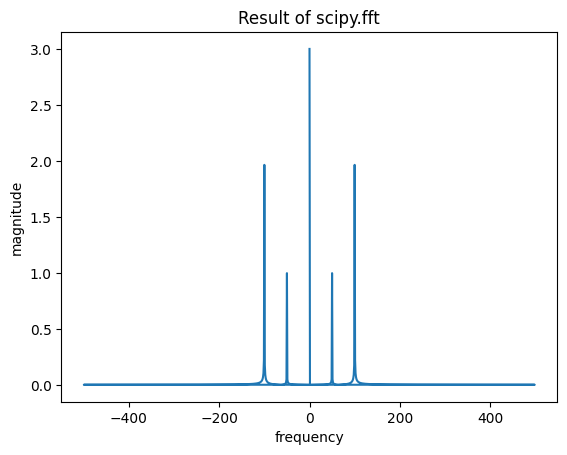

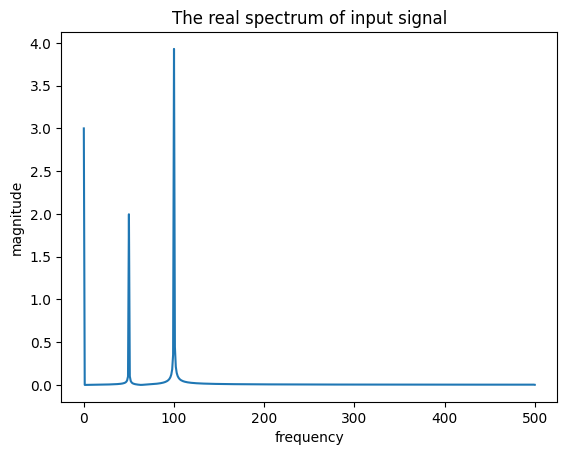

In [35]:
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt
from numpy.fft import fftfreq

frequency1 = 50
frequency2 = 100
fs = 1000
t = np.linspace(0,1,1000)
signal = 3 + 2 * np.sin(2 * np.pi * frequency1 * t) + 4 * np.sin(2 * np.pi * frequency2 * t)
plt.plot(signal)
plt.title("Input Signal of FFT")
plt.xlabel("time")
plt.ylabel("magnitude")
plt.show()

mag = np.abs(fft(signal))
mag = mag / len(signal)
freq = fftfreq(len(signal), 1/fs)
# print(freq)
plt.plot(freq,mag)
plt.title("Result of scipy.fft")
plt.xlabel("frequency")
plt.ylabel("magnitude")
plt.show()

mag_real = np.append(mag[0], mag[1:int(len(signal)/2)] * 2)
mag_real = np.append(mag_real, mag[int(len(signal)/2)])
# print(mag_real)
freq_real = np.arange(0,501)
plt.plot(freq_real,mag_real)
plt.title("The real spectrum of input signal")
plt.xlabel("frequency")
plt.ylabel("magnitude")
plt.show()

Here, let's analyze the spectrum. Due to the nature of scipy.fft, the order of the output is 
$$
0,1,2,...,\left \lfloor (N-1)/2 \right \rfloor,-\left \lfloor N/2 \right \rfloor,...,-2,-1
$$
To make the output have the right order, we need to specify the x-axis. And due to scipy.fft don't pay attention to fs, we need to scale the y-axis based on the fs to get the right x-axis. Numpy.fft.freqfft can help us correct the y-axis. It takes the length of signal and the fs as input and return the right y-aixs. 

Because the value of frequency term is a dot product between original signal and exponentail siganl, different lenght of signal will influence the value. To move the influence of signal length, we need to divide the value by the length of signal.

In this example, the signal is real valued, so the spectrum is symmetrical. To get the real value of frquency term, we should add the symmetrical part up. Note that the frequency of 0 and the Nyquist frequency doesn't have the counterpart, we don't have to multiply them by 2. Actually if the length of signal is odd, we won't get a frequency term which is equal to Nyquist frequency. For example, if the length of signal is 9, then the frequency are 0, fs/9, 2fs/9, 3fs/9, 4fs/9, -4fs/9, -3fs/9, -2fs/9, -fs/9 and the nyquist frequency is fs/2.

After doing all of above, we can find that value of frequency 0 is 3, value of frequency 50 is 2 and value of frequency 100 is 4, which conform with the signal generation process.

$my\_fft$ encapsulate all the steps above. It gets the original signal and the sampling rate as input and outputs the frequency and corresponding mag which is a complex number. The maximum of the frequency is the half of the fs.

$my\_ifft$ gets the mag of the $my\_fft$ as input and outputs the original signal.

The basic function of the fft is orthogonal. Why orthogonal is important? Because it can help us determine the cofficient conveniently. We can only multiple the signal and the basic function to get the cofficient of the basic funtion.

Help on function my_fft in module dsp:

my_fft(signal, fs)
    Description:
        Get the spectrum of the input signal
    Args:
        signal: input signal
        fs: sampling rate
    Returns:
        The spectrum of the input, containing the freq of x-axis and the mag of the y-axis. The mag is complex number.

Help on function my_ifft in module dsp:

my_ifft(mag)
    Description:
        Use the mag of my_fft to recover the original signal
    Args:
        mag: Output of my_fft
    Returns:
        The recovered original signal. It is complex-valued.



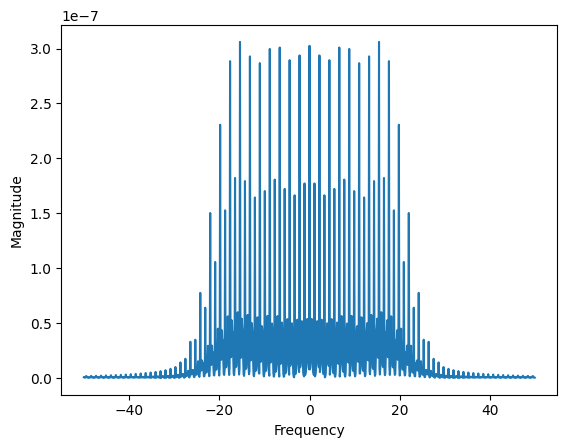

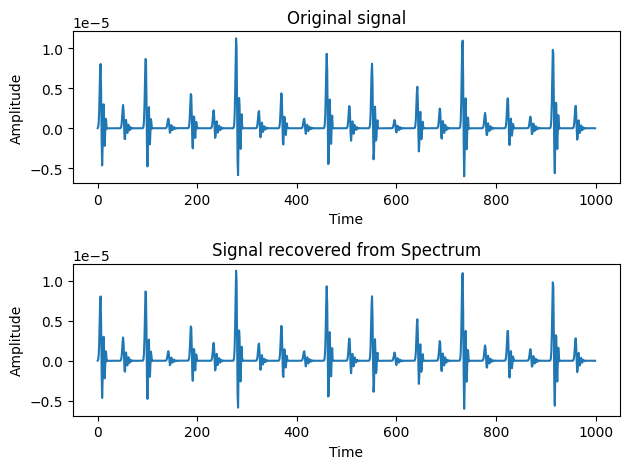

In [12]:
import numpy as np
from matplotlib import pyplot as plt
from dsp import my_fft, my_ifft, scg

help(my_fft)
help(my_ifft)

signal = scg()
fs = 100

freq, mag = my_fft(signal, fs)
# print(freq)


plt.plot(freq, np.abs(mag))
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

signal_recovered = my_ifft(mag)

fig, axis = plt.subplots(2,1)
axis[0].set_title("Original signal")
axis[0].set_xlabel("Time")
axis[0].set_ylabel("Amplitude")
axis[0].plot(signal)

axis[1].set_title("Signal recovered from Spectrum")
axis[1].plot(signal_recovered.real)
axis[1].set_xlabel("Time")
axis[1].set_ylabel("Amplitude")
plt.tight_layout()
plt.show()

## Frequency Domain Feature

### Power Spectral Density (PSD)
It is a tool used for frequency spectrum analysis to describe how the power of a signal varies with frequency.

The PSD represents the distribution of power across different frequencies in a signal, typically measured in power per Hertz (Hz). It can be computed by taking the squared magnitude of the Fourier transform of the signal. Specifically, for a time-domain signal x(t), the Power Spectral Density $S_{xx}(f)$ at frequency $f$ is calculated as:
$$
S_{xx}(f) = \lim_{{T \to \infty}} \frac{1}{T} \left| \int_{-T/2}^{T/2} x(t) e^{-j 2 \pi f t} \,dt \right|^2
$$
where $x$ denotes the time-domain signal and $j$ denotes the imaginary unit.

Help on function psd in module dsp:

psd(signal, fs)
    Description:
        Extract the power spectral density (PSD) of a signal.
    Params:
        signal (numpy.ndarray): Input signal.
        fs (float): Sampling frequency of the signal.
    Returns:
        numpy.ndarray: Frequency vector.
        numpy.ndarray: Power spectral density values.



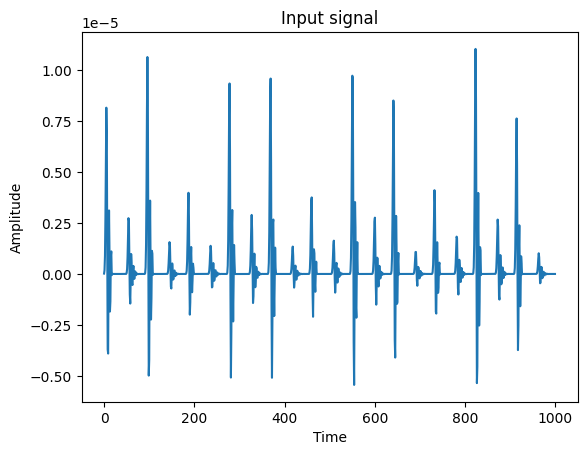

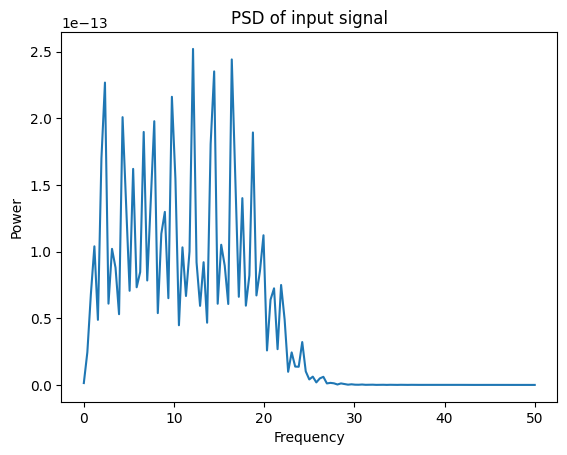

In [61]:
import numpy as np
from dsp import psd, scg
import matplotlib.pyplot as plt

help(psd)

fs = 100
signal = scg()
f,p = psd(signal, fs)

plt.title("Input signal")
plt.plot(signal)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

plt.title("PSD of input signal")
plt.plot(f,p)
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.show()

# Time-Frequency domain

## Short Time Fourier Transform (STFT)

The Short-Time Fourier Transform (STFT) is a method used to analyze the frequency characteristics of time-varying signals. The STFT works by dividing a signal into shorter segments of time and performing a Fourier Transform on each segment to capture the signal's frequency information as it changes over time. The formula for the STFT is given by:
$$
STFT\{x(t)\}(\tau, \omega) = \int_{-\infty}^{+\infty} x(t) \cdot w(t-\tau) \cdot e^{-j\omega t} dt
$$

Here's an explanation of the variables used:

- $x(t)$: The continuous-time signal to be analyzed.
- $\tau$: The time variable, representing the position of the analysis window on the signal.
- $\omega$: The frequency variable, used for computing the frequency components in the Fourier Transform.
- $w(t-\tau)$: The window function (e.g., Hamming window, Hanning window, etc.), centered at the time point $\tau$. The window function localizes the signal in time so that the frequency content of the signal can be analyzed around each time point $\tau$. The choice of window function has a significant impact on the STFT results.
- $e^{-j\omega t}$: The complex exponential function, which is the core part of the Fourier Transform, used to transform the signal into the frequency domain.
- $STFT\{x(t)\}(\tau, \omega)$: The result of the STFT, which is a function of time $\tau$ and frequency $\omega$, representing the complex amplitude of the frequency components of the signal near the time $\tau$.

In practice, signals are often discrete, so the STFT is typically applied to discrete-time signals. For a discrete-time signal $x[n]$, the discrete form of the STFT can be written as:
$$
STFT\{x[n]\}(m, \omega) = \sum_{n=-\infty}^{+\infty} x[n] \cdot w[n-m] \cdot e^{-j\omega n}
$$

Where:

- $x[n]$: The discrete-time signal.
- $m$: The discrete-time variable, representing the position of the analysis window on the signal.
- $\omega$: The discrete frequency variable, typically taking the value $\omega = 2\pi k/N$, where $k$ is the frequency index, and $N$ is the number of points in the DFT.
- $w[n-m]$: The discrete window function, centered at the sample point m.
- $STFT\{x[n]\}(m, \omega)$: The discrete STFT result, representing the complex amplitude of the frequency components of the signal near the sample point m.

The result of the STFT can be used to produce a time-frequency spectrogram, which is a two-dimensional plot with time on the horizontal axis, frequency on the vertical axis, and color or brightness representing the energy or amplitude of the signal at specific times and frequencies. The max number of y-axis (frequency) is the half of the fs which is based on the Nyquist sampling princple, but the number of frequency in y-axis is the half of the nperseg. The number of the x-axis depends on the nperseg and the noverlap and the max number of the x-axis is (length of signal / fs). The output Z is complex-valued.

### Windows for STFT

To get the time information of the signal, we segment the signal and view the signal in the segment as stationary signal. However, when the signal does not complete an integer number of cycles, an issue known as Frequency Leakage may occur which can pose challenges in reconstructing the original signal based on the spectrum. To minimize the impact of Frequency Leakage, the original signal can be multiplied by a window function.

Three commonly used window functions for STFT include:

1. Rectangular Window: $w[n] = 1$
   
   This is the simplest window function, which gives equal weight to each point. The rectangular window has optimal time resolution but poor frequency resolution because its spectrum contains many side lobes.


2. Hamming Window: $w[n] = 0.54 - 0.46 \cos\left(\frac{2\pi n}{N-1}\right)$
   
   The Hamming window has better frequency resolution due to its lower side lobes, but it sacrifices some time resolution. It is suitable for scenarios that require good frequency resolution with lower side lobes.


3. Hanning Window (also known as Hann Window): $w[n] = 0.5 \left(1 - \cos\left(\frac{2\pi n}{N-1}\right)\right)$
   
   The Hanning window is similar to the Hamming window but has a wider main lobe and lower side lobes. It is suitable for scenarios that require even lower side lobes and can accept a slightly wider main lobe.

Here's an example demonstrating these three window functions:

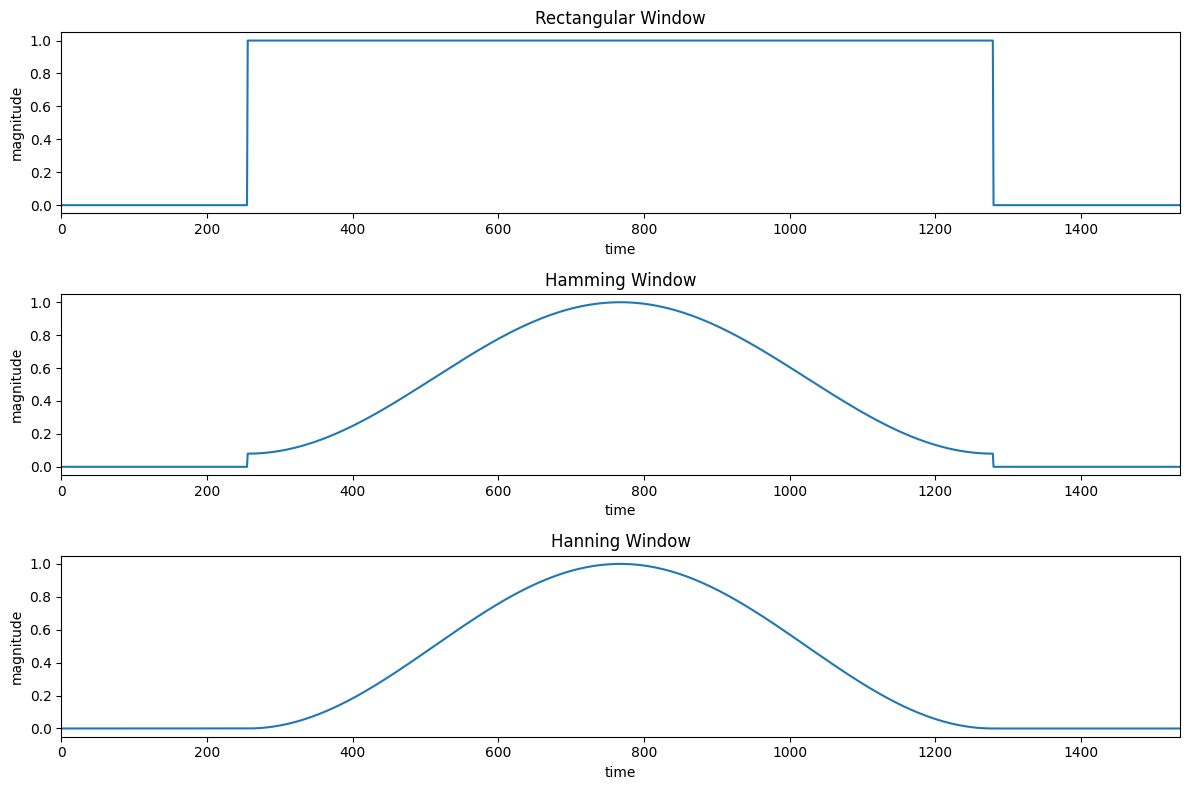

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# length of the window
N = 1024

# extended length of window
N_extended = N + 512

rectangular_window = np.ones(N)
rectangular_window = np.pad(rectangular_window, (256, 256), 'constant', constant_values=(0, 0))

hamming_window = 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(N) / (N - 1))
hamming_window = np.pad(hamming_window, (256, 256), 'constant', constant_values=(0, 0))

hanning_window = 0.5 * (1 - np.cos(2 * np.pi * np.arange(N) / (N - 1)))
hanning_window = np.pad(hanning_window, (256, 256), 'constant', constant_values=(0, 0))

plt.figure(figsize=(12, 8))
plt.subplot(311)
plt.plot(rectangular_window)
plt.title("Rectangular Window")
plt.xlabel("time")
plt.ylabel("magnitude")
plt.xlim(0, N_extended)

plt.subplot(312)
plt.plot(hamming_window)
plt.title("Hamming Window")
plt.xlabel("time")
plt.ylabel("magnitude")
plt.xlim(0, N_extended)

plt.subplot(313)
plt.plot(hanning_window)
plt.title("Hanning Window")
plt.xlabel("time")
plt.ylabel("magnitude")
plt.xlim(0, N_extended)

plt.tight_layout()
plt.show()

Help on function my_stft in module dsp:

my_stft(signal, fs, plot=False, window='hann', nperseg=256, noverlap=None, nfft=None, detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=-1, scaling='spectrum')
    Description:
        Compute the Linear Spectrogram of a signal using Short-time Fourier Transform (STFT).
    
    Params:
        signal (numpy.ndarray): The input signal.
        fs (int): The sample rate of the signal.
        nperseg (int, optional): The size of the analysis window in samples. Default is 256.
        The other parameters are seldom used.
    
    Returns:
        freqs (numpy.ndarray): The frequency values in Hz.
        times (numpy.ndarray): The time values in seconds.
        spectrogram (numpy.ndarray): The computed linear spectrogram.



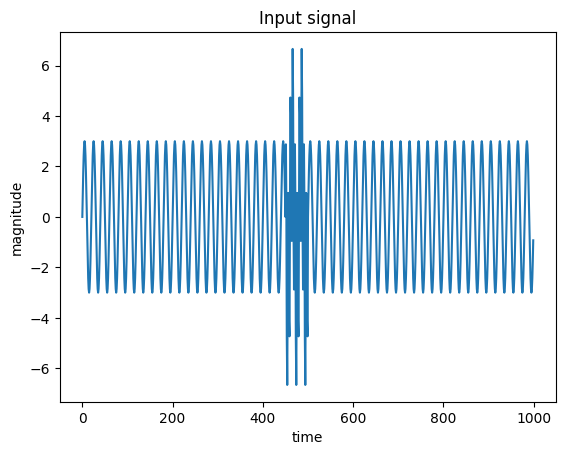

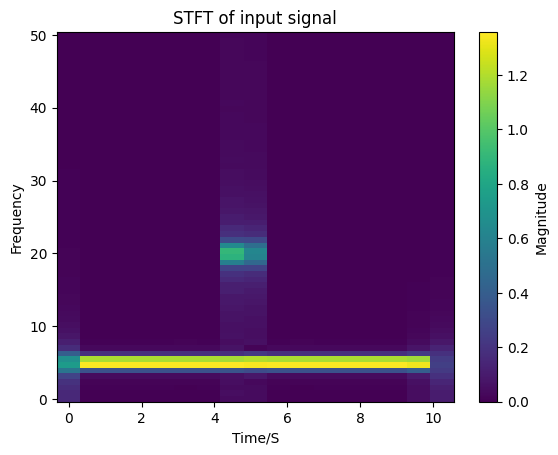

In [68]:
import numpy as np
from dsp import my_stft, scg
import matplotlib.pyplot as plt

help(my_stft)

fs, N = 100, 1000  # 100 Hz sampling rate for 10 s signal
t = np.arange(N) / fs # time indexes for signal
t_short = np.arange(50) / fs
freq1 = 5
freq2 = 20

signal1 = 3 * np.sin(2 * np.pi * freq1 * t)
signal2 = 4 * np.sin(2 * np.pi * freq2 * t_short)

signal = np.concatenate((np.zeros(450),signal2,np.zeros(500))) + signal1

plt.plot(signal)
plt.title("Input signal")
plt.xlabel("time")
plt.ylabel("magnitude")
plt.show()


fs = 100 # sampling frequency
window = 'hann' # window type
nperseg = 128 # length of frame

# STFT
f, t, Z = my_stft(signal, plot=True, fs=fs, window=window, nperseg=nperseg)

### Resolution Aanlysis
The longer the frame, the frequency information is more accurate, the time information is less accurate. The above is what we call heisenberg uncertainty principle.

Here is an example to illustrate it. At first, the length of frame is 64, then we increase it to 128, and we can find that the frequency information become more accurate and the time information become less accurate. And if we decrease the length of frame to 32, the location of the sin wave of 20hz become more accurate, while it lose some information of frequency.

In conclusion, we can't achieve both high resolution of time and frquency in stft which is a disadvantage of stft.

Help on function my_stft in module dsp:

my_stft(signal, fs, plot=False, window='hann', nperseg=256, noverlap=None, nfft=None, detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=-1, scaling='spectrum')
    Description:
        Compute the Linear Spectrogram of a signal using Short-time Fourier Transform (STFT).
    
    Params:
        signal (numpy.ndarray): The input signal.
        fs (int): The sample rate of the signal.
        nperseg (int, optional): The size of the analysis window in samples. Default is 256.
        The other parameters are seldom used.
    
    Returns:
        freqs (numpy.ndarray): The frequency values in Hz.
        times (numpy.ndarray): The time values in seconds.
        spectrogram (numpy.ndarray): The computed linear spectrogram.



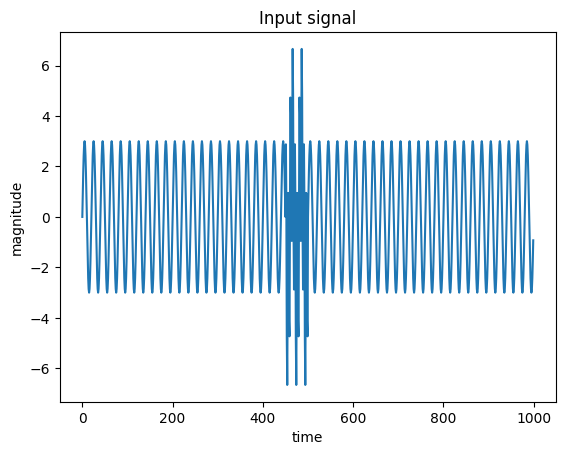

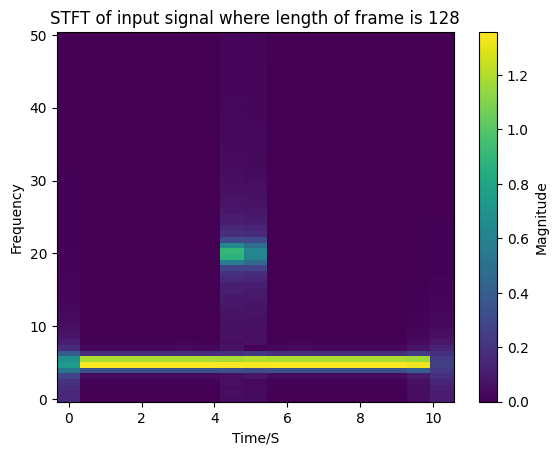

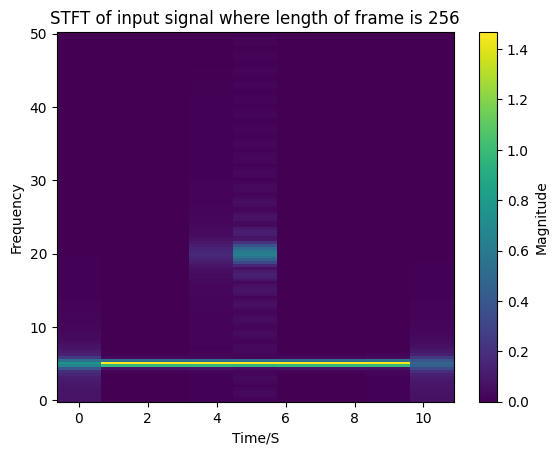

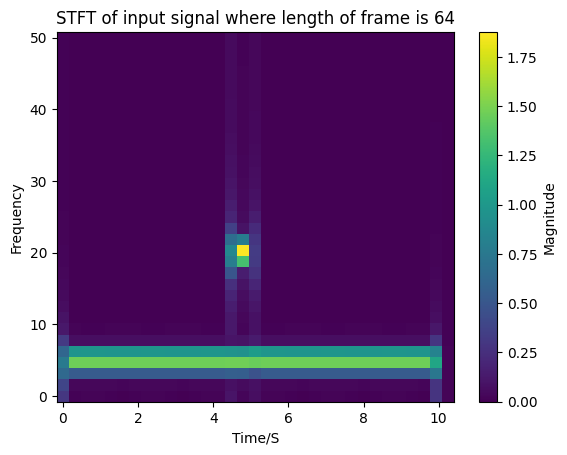

In [71]:
import numpy as np
from dsp import my_stft, scg
import matplotlib.pyplot as plt

help(my_stft)

fs, N = 100, 1000  # 100 Hz sampling rate for 10 s signal
t = np.arange(N) / fs # time indexes for signal
t_short = np.arange(50) / fs
freq1 = 5
freq2 = 20

signal1 = 3 * np.sin(2 * np.pi * freq1 * t)
signal2 = 4 * np.sin(2 * np.pi * freq2 * t_short)

signal = np.concatenate((np.zeros(450),signal2,np.zeros(500))) + signal1

plt.plot(signal)
plt.title("Input signal")
plt.xlabel("time")
plt.ylabel("magnitude")
plt.show()


fs = 100 # sampling frequency
window = 'hann' # window type
nperseg = 128 # length of frame

# STFT
f, t, Z = my_stft(signal, plot=False, fs=fs, window=window, nperseg=nperseg)
plt.title("STFT of input signal where length of frame is 128")
plt.pcolormesh(t, f, np.abs(Z))
plt.xlabel("Time/S")
plt.ylabel("Frequency")
plt.colorbar(label='Magnitude')
plt.show()

f, t, Z = my_stft(signal, plot=False, fs=fs, window=window, nperseg=2*nperseg)
plt.title("STFT of input signal where length of frame is 256")
plt.pcolormesh(t, f, np.abs(Z))
plt.xlabel("Time/S")
plt.ylabel("Frequency")
plt.colorbar(label='Magnitude')
plt.show()

f, t, Z = my_stft(signal, plot=False, fs=fs, window=window, nperseg=nperseg/2)
plt.title("STFT of input signal where length of frame is 64")
plt.pcolormesh(t, f, np.abs(Z))
plt.xlabel("Time/S")
plt.ylabel("Frequency")
plt.colorbar(label='Magnitude')
plt.show()

## Wavelet Analysis

STFT has a serious problem, that is we can't get a good time and frequency resolution. The bigger the nperseg, the better the frequency resolution, but the worse time resolution, vice versa. The above problem is caused by the fact that the nperseg is fixed. So we introduce the wavelet analysis which is a MRA method. MRA (multiresolution analysis) is designed to give good time resolution and poor frequency resolution at high frequencies and good frequency resolution and poor time resolution at low frequencies.Generally, the basic function of wavelet transform is orthogonal and normalized (normalized makes the transformed signal have the same energy at every scale).

### Mexican Hat Wavelet

It is the second derivative of the Gaussian function.

Gaussian function:
$$
w(t) = \frac{1}{\sqrt{2\pi} \cdot \sigma} e^{\frac{-t^2}{2 \sigma^2}}
$$
where $\sigma$ is the standard deviation and $t$ is time.

Second derivative of the Gaussian function:
$$
\psi(t) = \frac{1}{\sqrt{2 \pi} \cdot \sigma^3} \left( e^{\frac{-t^2}{2 \sigma^2}} \cdot \left( \frac{t^2}{\sigma^2} - 1 \right) \right)
$$

Help on function mexican_hat_wavelet in module dsp:

mexican_hat_wavelet(sigma, length)
    Description:
        Generate the mexican hat wavelet. It is the second derivative of the Gaussian function.
    Args:
        sigma: It has the same meaning in the Gaussian function
        length: length of the wavelet
    Returns:
        The mexican hat wavelet



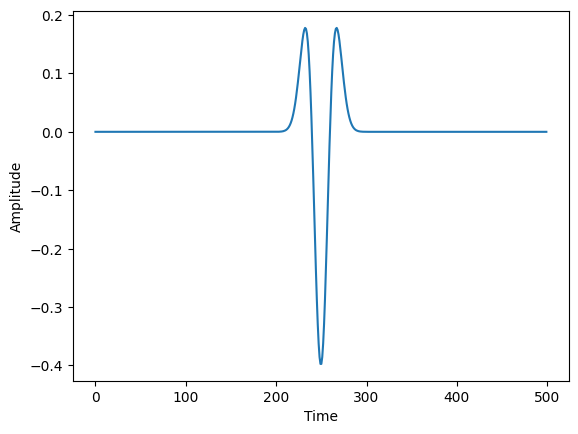

In [63]:
import matplotlib.pyplot as plt
from dsp import mexican_hat_wavelet

help(mexican_hat_wavelet)

sigma = 1
length = 50
psi = mexican_hat_wavelet(sigma, length)
plt.plot(psi)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

### Morlet Wavelet

It is defined as follows:
$$
w(t) = e^{i a t} \cdot e^{-\frac{t^2}{2\sigma}}
$$
where $t$ is the time variable, $a$ controls the frequency of the sinusoidal oscillation, and $\sigma$ controls the width of the Gaussian envelope.

Help on function morlet_wavelet in module dsp:

morlet_wavelet(length, sigma, a=5)
    Description:
        Generate the morlet wavelet which value is complex.
    Args:
        length: Length of the wavelet.
        sigma: Scaling parameter that affects the width of the window.
        a: Modulation parameter. Default is 5
    Returns:
        The morlet wavelet which is complex-valued.



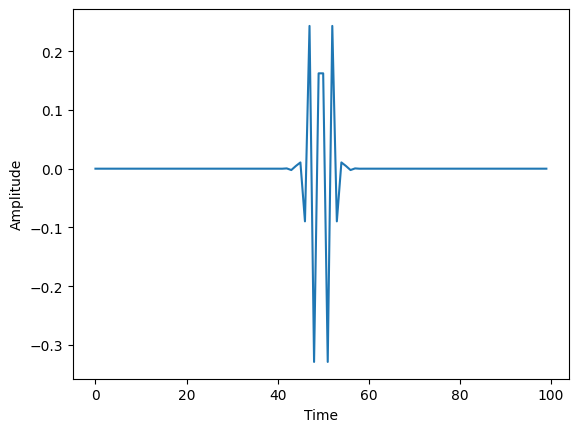

In [64]:
import matplotlib.pyplot as plt
from dsp import morlet_wavelet

help(morlet_wavelet)

length = 100
sigma = 2
a = 5
omega = morlet_wavelet(length, sigma, a)
plt.plot(omega.real)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

### Continuous Wavelet Transform (CWT)

In CWT, the signal can be transformed by:

$$
CWT_x^\psi(\tau,s) = \Psi_x^\psi(\tau,s) = \frac{1}{\sqrt{|s|}} \int x(t) \psi^* \left( \frac{t - \tau}{s} \right) dt
$$

where the $\psi$ denotes the mother wavelet, $\tau$ denotes the translation of the wavelet, and $s$ denotes the sacle of the wavelet. $\tau$ and $s$ are all incremented continuously. However, if this transform needs to be computed by a computer, then both parameters are increased by a sufficiently small step size. This corresponds to sampling the time-scale plane.

### Inverse CWT

$$
x(t)=\frac{1}{c_{\psi}^{2}} \int_{s} \int_{\tau} \Psi_{x}^{\psi}(\tau, s) \frac{1}{s^{2}} \psi\left(\frac{t-\tau}{s}\right) d \tau d s
$$

where $c_{\psi}$ is a constant that depends on the wavelet used and the other symbols are described in above cell. $c_{\psi}$ can be calculated as follows:
$$
c_{\psi}=\left\{2 \pi \int_{-\infty}^{\infty} \frac{|\hat{\psi}(\xi)|^{2}}{|\xi|} d \xi\right\}^{1 / 2}
$$

where $\hat{\psi(\xi)}$ is the FT of $\psi(t)$

Help on function my_cwt in module dsp:

my_cwt(signal, scales, wavelet, fs, show=False)
    Description:
        Compute the cwt of the input signal
    Args:
        signal: input signal
        scales: the scales of wavelet, we can use pywt.scale2frequency to convert them to corresponding frequency
        wavelet: the type of the wavelet, there are "morl", "mexh" and so on. You can use
            wavlist = pywt.wavelist(kind='continuous') to get the available wavelet
        fs: the sampling frequency
        show: whether to show the result
    Returns:
        cofficient: the result of cwt. The length of y-axis depends on scales and length of x-axis depends on length of
            input signal
        frequencies: the corresponding frequencies to  scales



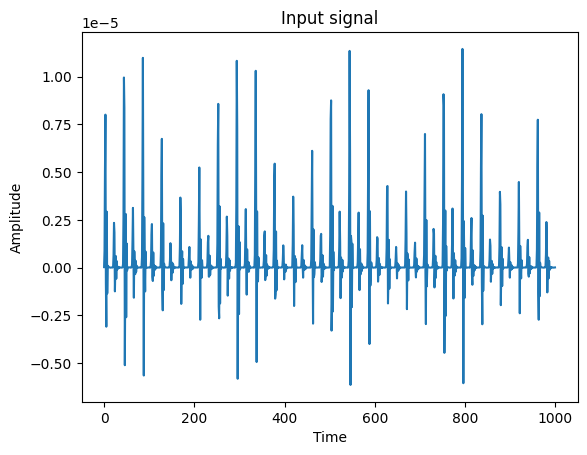

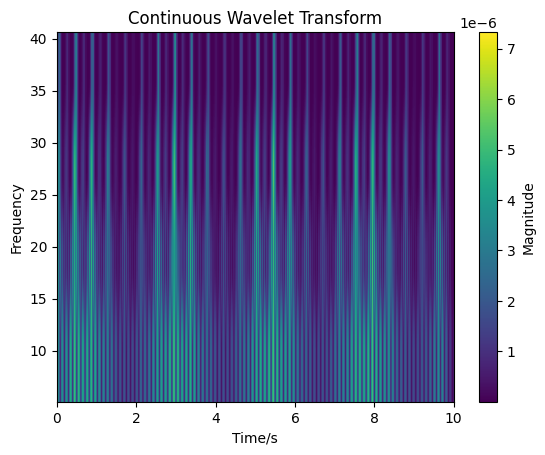

In [65]:
from dsp import my_cwt, scg
import numpy as np
import matplotlib.pyplot as plt

help(my_cwt)

fs = 100
signal = scg()
plt.title("Input signal")

plt.plot(signal)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

scales = np.array([2,4,8,16])
wavelet = 'morl'

coefficients, frequencies = my_cwt(signal, scales, wavelet, fs, True)

## Polynomial Chirplet Transform (PCT)
PCT is a signal processing technique and a variant of the Chirplet Transform. The Chirplet Transform is a method used to analyze non-stationary modulations in signals, and PCT further introduces polynomial functions to enhance its analytical capabilities.

In the Chirplet Transform, "Chirp" refers to a signal with a frequency that varies over time, and a "Chirplet" is a wavelet associated with a Chirp. PCT introduces polynomial modulation functions, allowing the frequency, phase, and amplitude of Chirplets to vary according to the shape of the polynomial.

The core idea of PCT is to use polynomials to describe the nonlinear modulation characteristics of a signal, thereby better capturing the complex structures and non-stationary nature of the signal. This method is effective for analyzing signals where frequency, phase, and amplitude change over time.

### Chirplet Transform

The Chirplet Transform of a signal $x(t)$ is often represented as:
$$
C(a, b, \omega, \tau) = \int_{-\infty}^{\infty} x(t) \psi_{a, b, \omega, \tau}^*(t) \, dt
$$
where * denotes the complex conjugate and $\psi_{a, b, \omega, \tau}(t)$ is the Chirplet defined as:
$$
\psi_{a, b, \omega, \tau}(t) = e^{j(\omega t + \frac{a}{2}t^2 + b t + \tau)}
$$

### Polynomial Chirplet Transform

The Polynomial Chirplet Transform extends the Chirplet Transform by introducing a polynomial modulation. The general form is:
$$
C(a, b, \omega, \tau, P(t)) = \int_{-\infty}^{\infty} x(t) \psi_{a, b, \omega, \tau, P(t)}^*(t) \, dt
$$
Here, $P(t)$ is a polynomial function that modulates the Chirplet parameters.
$$
\psi_{a, b, \omega, \tau, P(t)}(t) = e^{j(\omega t + \frac{a}{2}t^2 + b t + \tau + P(t))}
$$

Help on function chirplet_transform in module dsp:

chirplet_transform(signal, show=False)
    Description:
        Generate the chirplet_trainsform of the input signal
    Args:
        signal: Input signal
        show: whether to show the result of the chirplet transform
    Returns:
        The result of the chirplet transform



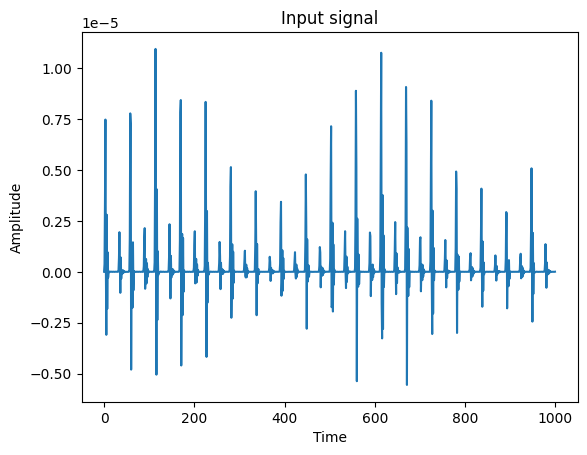

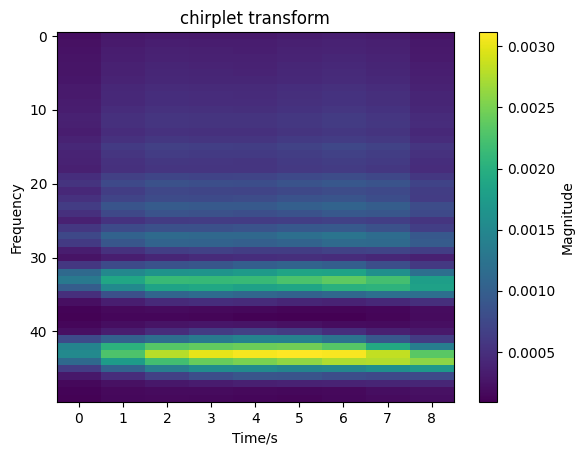

In [66]:
import numpy as np
from dsp import chirplet_transform, scg
import matplotlib.pyplot as plt

help(chirplet_transform)

signal = scg()
plt.title("Input signal")
plt.plot(signal)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

ct_matrix = chirplet_transform(signal, show=True)

## Wigner Ville Distribution (WVD)


WVD is a time-frequency representation method widely used in signal processing and analysis. The primary goal of the Wigner-Ville Distribution is to provide a representation of the instantaneous frequency distribution of a signal. Unlike traditional methods such as Fourier transform and short-time Fourier transform, the Wigner-Ville Distribution offers more detailed information in both time and frequency domains, simultaneously depicting the variations of a signal over time and frequency.

The definition of WVD is as follows:
$$
W_x(t, f) = \int_{-\infty}^{\infty} x\left(t + \frac{\tau}{2}\right) \cdot \overline{x\left(t - \frac{\tau}{2}\right)} \cdot e^{-2\pi i f \tau} \,d\tau
$$
Here, $W_x(t, f)$ represents the WVD, $x(t)$ is the input signal, $\overline{x(t)}$ denotes the complex conjugate of $x(t)$, $t$ is time, and $f$ is frequency. The WVD describes the transient characteristics of a signal by computing the autocorrelation of the signal at different time windows.

The advantages of WVD include its adaptability to non-stationary signals and its ability to capture the transient features of a signal. However, WVD also has some drawbacks, such as the presence of cross terms that may introduce additional complexity to the analysis.

Help on function my_wvd in module dsp:

my_wvd(signal, show=False)
    Description:
        Analyze the time-frequency characteristics of a signal using the Wigner-Ville Transform (WVT) and visualize the results.
    
    Params:
        signal (numpy.ndarray): The input signal.
        show: whether to plot the result
    Returns:
        tfr_wvd (numpy.ndarray): The time-frequency representation (WVD) of the signal.
        t_wvd (numpy.ndarray): Time values corresponding to the WVD.
        f_wvd (numpy.ndarray): Normalized frequency values corresponding to the WVD.



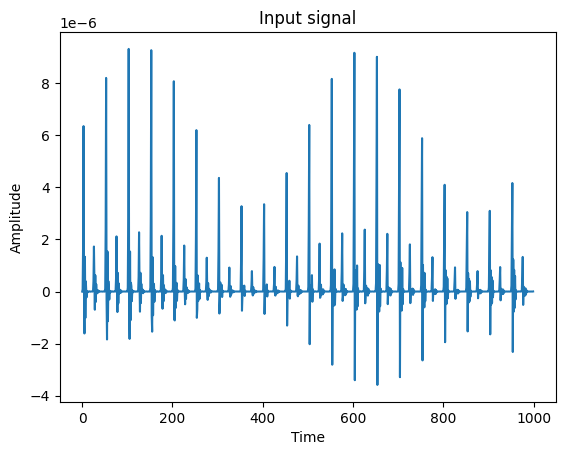

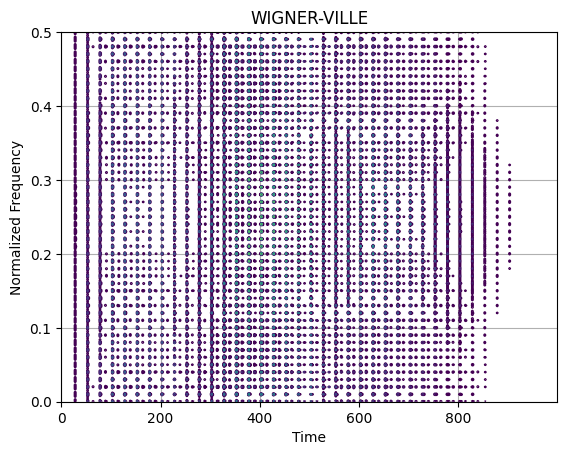

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from dsp import my_wvd, scg

help(my_wvd)

signal = scg()
plt.title("Input signal")
plt.plot(signal)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

matrix, t, f = my_wvd(signal, show=True)

## SynchroSqueezing Transform (SST)

SST is a signal processing technique designed to analyze the time-frequency structure in non-stationary and non-linear signals. SST aims to enhance the resolution of signals in the time-frequency domain, particularly when dealing with non-linear and non-stationary conditions.


1. **Time-Frequency Localization:** SST seeks to capture the instantaneous frequency information of a signal by localizing it on the time-frequency plane. This allows for a more accurate analysis of the time and frequency characteristics of non-stationary signals.

2. **Reassignment Representation:** SST employs a technique known as reassignment representation, redistributing the signal on the time-frequency plane. This helps improve the resolution of local structures in the signal, making it easier to identify and analyze features in the time-frequency domain.

3. **Sync Reassignment:** The core idea of SST involves remapping the spectral information of the Fourier transform onto the time-frequency plane, obtaining a more refined and accurate time-frequency analysis of the signal. This sync reassessment allows for better detection of instantaneous frequency changes in the signal.


Help on function sst_stft in module dsp:

sst_stft(signal, fs, window, nperseg=256, show=False, n_fft=None, hop_len=1, modulated=True, ssq_freqs=None, padtype='reflect', squeezing='sum', gamma=None, preserve_transform=None, dtype=None, astensor=True, flipud=False, get_w=False, get_dWx=False)
    Description:
        Synchrosqueezed Short-Time Fourier Transform.
    Args:
        signal: the input signal
        fs: frequency of sampling
        window: type of the window
        nperseg: Length of each segment
        show: whether to show the result
        n_fft: length of fft
        The other parameters are seldom used.
    Returns:
        Tx: Synchrosqueezed STFT of `x`, of same shape as `Sx`.
        Sx: STFT of `x`
        ssq_freqs: Frequencies associated with rows of `Tx`.
        Sfs: Frequencies associated with rows of `Sx` (by default == `ssq_freqs`).



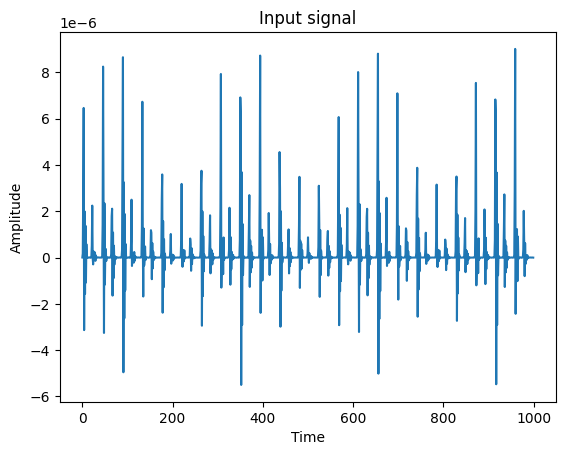

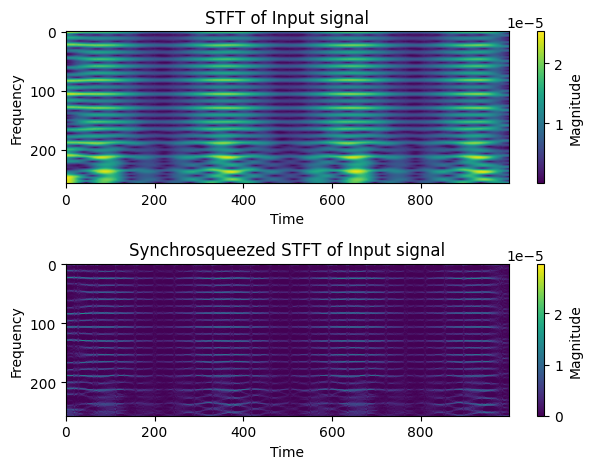

In [68]:
from dsp import sst_stft, scg
import numpy as np
import matplotlib.pyplot as plt

help(sst_stft)

fs = 100
signal = scg()
plt.title("Input signal")
plt.plot(signal)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

Tx, Sx, ssq_freqs, Sfs= sst_stft(signal, window="ham", nperseg = 128, fs = fs, show=True)

Help on function sst_cwt in module dsp:

sst_cwt(signal, wavelet, scales, nv, fs, gamma=None, show=False)
    Description:
        Synchrosqueezed Continuous Wavelet Transform
    Args:
        signal: input of signal
        wavelet: the type of mother wavelet
        scales: how to scale the output, log or linear
        nv: number of voices
        fs: sampling frequency
        gamma: CWT phase threshold
        show: whether to show the result
    Returns:
        Tx: Synchrosqueezed CWT of `x`. (rows=~frequencies, cols=timeshifts)
            (nf = len(ssq_freqs); n = len(x))
            `nf = na` by default, where `na = len(scales)`.
        Wx: Continuous Wavelet Transform of `x`, L1-normed (see `cwt`).
        ssq_freqs: Frequencies associated with rows of `Tx`.
        scales: Scales associated with rows of `Wx`.



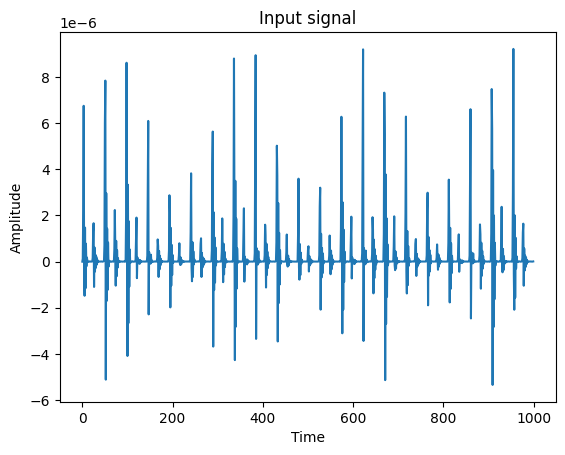

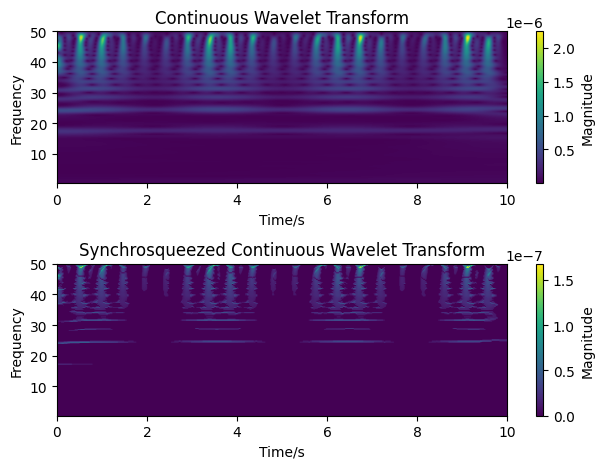

In [69]:
from dsp import sst_cwt, scg
import numpy as np
import matplotlib.pyplot as plt

help(sst_cwt)

fs = 100
signal = scg()
plt.title("Input signal")
plt.plot(signal)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

Tx, Wx, ssq_freqs, scale= sst_cwt(signal, wavelet="morlet", scales="log", nv=20, fs = fs,gamma = 3e-7, show=True)